# Stack Overflow Post Categorisation

In this project, we aim to build a system to compile common challenges faced by software developers along with their solutions. The challenges compiled in this system will be related to NLP and will be categorise based on **NLP tasks** in languange modelling, classified into **12 categories**.

The challenges and solutions are collected from Stack Overflow, which is commonly used among developers to share their problem in the discussion forums. The solution provided on Stack Overflow are written by experience developers, making them more credible compared to ChatGPT. Therefore, with this system, we aim to categorise each post to increase efficiency in finding solution to any challenges related to NLP within developers in our company.

# 1. Data collection

We begin with collecting the challenges and solutions from Stack Overflow using Stack Exchange API. The [documentation](https://api.stackexchange.com/docs) provided by the Stack Exchange API offers a comprehensive explanation on how to utilize their API to collect the desired data, and we also provide a more detailed explanation related to our code components in the report.

Here, we define a class called `get_stackoverflow_data` to encapsulate the end-to-end process of data collection to retrieve the post questions and answers. The class receives arguments to specify the number of data to retrieve and the specific tags or collective name of the posts to be collected. The final output of this class is a single JSON file containing post information, including the post title, question, and answer.

Each class process consist of two data request. The first one start by requesting the question information, defined in the `get_stackoverflow_posts` method. It then continues by requesting the answer information, which is performed by executing either the `get_stackoverflow_answers` or `get_top_stackoverflow_answers` method. The `get_stackoverflow_answers` method is executed if the question request was made with filter condition for posts with an accepted answer. But, if the question request was made for posts that have at least one answer (not necessarily an accepted answer), the `get_top_stackoverflow_answers` method is used to retrieve answer with the highest score. Lastly, the `get_stackoverflow_posts_answers` method is executed to save the result into a single JSON file, which is stored into local device.

In [ ]:
# Supress warnings to remove less necessary warnings
import warnings
warnings.filterwarnings("ignore")

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [ ]:
import requests
import json

# Define a class to perform data collection
class get_stackoverflow_data:

  # 1. Initialise variables
  def __init__(self, tag, num_of_data, filename, only_collective=False, not_accepted_answer=False):

    self.tags = tag
    self.num_of_data = num_of_data
    self.filename = filename
    self.params = {
        "site": "stackoverflow",
        "filter": "withbody",
        "pagesize": 100,
        "key": "rl_MFjddDouDky4bfDeQMEA5WDN3"}
    self.only_collective = only_collective
    self.not_accepted_answer = not_accepted_answer

    # Initialise empty variables to store the results
    self.posts = []
    self.post_ids = set()
    self.num_of_retrieved_data = 0


  # 2. Function to perform loop data request for posts (questions)
  def get_posts_loop(self, post_url, tag=None):

      page = 1

      while self.num_of_retrieved_data < self.num_of_data:

        if self.only_collective:
          self.post_params["collective"] = "nlp"
        else:
          self.post_params["tagged"] = tag

        self.post_params["page"] = page

        get_posts_with_accepted_answer_id = requests.get(post_url, params=self.post_params).json()

        # The data sucessfully retrieved indicated with 'items' keys in the output
        if "items" in get_posts_with_accepted_answer_id:

          # Check the 'question_id' to avoid duplicated posts
          for post in get_posts_with_accepted_answer_id['items']:

            if post['question_id'] not in self.post_ids and post['answer_count'] > 0:

              self.posts.append(post)
              self.post_ids.add(post['question_id'])
              self.num_of_retrieved_data += 1

              if self.num_of_retrieved_data >= self.num_of_data:
                break

          page += 1

        else:
          # Exit if no more result contained
          break


  # 3. Function to specify parameters for different posts (questions) request
  def get_stackoverflow_posts(self):

    # Finalise the parameters and URL that want to be used to retrieve posts from the API
    self.post_params = self.params.copy()

    if not self.not_accepted_answer:
      # Get posts that has accepted answer with advanced search url
      post_url = "https://api.stackexchange.com/2.3/search/advanced?order=desc&sort=activity&accepted=True"
    else:
      # Get posts that has at least one answer
      post_url = "https://api.stackexchange.com/2.3/questions"

     # Retrieve post data from 'NLP' collective
    if self.only_collective:
      self.get_posts_loop(post_url)

    # Perform looping to retrieve post data from multiple tags
    for tag in self.tags:
      self.get_posts_loop(post_url, tag)

    # Print a message if the target number of data has not been achieved
    if self.num_of_retrieved_data < self.num_of_data:
      print("The requested number of data exceeds the currently available data.")

    if self.only_collective:
      print(f"Total {self.num_of_retrieved_data} posts sucessfully retrieved from the \"NLP\" collective.")
    else:
      print(f"Total {self.num_of_retrieved_data} posts sucessfully retrieved from the \"{self.tags}\" tags.")


  # 4. Function to perform data request for accepted answer based on collected questions using accepted_answer_id
  def get_stackoverflow_answers(self):

    # Compile the accepted_answer_id into a list
    accepted_answer_ids = []

    for post in self.posts:
        accepted_answer_ids.append(str(post['accepted_answer_id']))

    # Return the answer 'body' into a dictionary with format: 'answer_id' as the key and 'body' as the value
    self.answer_body = {}

    # Perform looping since the max size for each request are 100 semicolon delimited ids
    for page in range(0, len(accepted_answer_ids), self.params['pagesize']):

      sliced_accepted_answer_ids = accepted_answer_ids[page:page+self.params['pagesize']]

      accepted_answer_ids_str = ";".join(sliced_accepted_answer_ids)

      # Get the accepted answer body with filtering by 'accepted_answer_id' for each post
      answer_url = f"https://api.stackexchange.com/2.3/answers/{accepted_answer_ids_str}"

      get_answer_body = requests.get(answer_url, params=self.params).json()

      for answer in get_answer_body["items"]:
        self.answer_body[answer['answer_id']] = answer['body']

    print(f"Total {len(self.answer_body)} accepted answered sucessfully retrieved from each posts.")

  # 5. Function to perform data request for highest score answer based on collected questions using question_id
  def get_top_stackoverflow_answers(self):

    # Compile the accepted_answer_id into a list
    question_id = []

    for post in self.posts:
        if post['answer_count'] > 0 and "answer_body" not in post:

          question_id.append(str(post['question_id']))

          answers_url = f"https://api.stackexchange.com/2.3/questions/{str(post['question_id'])}/answers"

          self.params["order"]= "desc"
          self.params["sort"] = "votes"

          get_answers_body = requests.get(answers_url, params=self.params).json()

          if "items" in get_answers_body:
            best_answer = get_answers_body["items"][0]

            # Append the answer to the posts
            post['accepted_answer_id'] = best_answer['answer_id']
            post['answer_body'] = best_answer['body']

          else:
            print(f"No answers found for question_id: {post['question_id']}")

    print(f"Total {len(question_id)} accepted answered sucessfully retrieved from each posts.")

  # 6. Function to combine collected questions and answers into a json file
  def get_stackoverflow_posts_answers(self):

    # Mapped the answer body by 'accepted_answer_id' into the posts question
    if not self.not_accepted_answer:
      for post in self.posts:
        post['answer_body'] = self.answer_body[post['accepted_answer_id']]

    # Save the result into a json file
    with open(self.filename, 'w') as file:
      json.dump(self.posts, file)

    print(f"Output successfully saved into {self.filename}.")

The **first** post data request is done by collecting posts with an accepted answer from 'NLP' collective.

In [ ]:
### PART 1:
# Collecting posts from 'NLP' collective only
stackoverflow_collective_df = get_stackoverflow_data(tag=[], num_of_data=20000, filename='stack_overflow_posts_nlp_collective.json', only_collective=True)
stackoverflow_collective_df.get_stackoverflow_posts()

The requested number of data exceeds the currently available data.
Total 2500 posts sucessfully retrieved from the "NLP" collective.


In [ ]:
# Collecting accepted answer for 'NLP' collective and save into a json file
stackoverflow_collective_df.get_stackoverflow_answers()
stackoverflow_collective_df.get_stackoverflow_posts_answers()

Total 2500 accepted answered sucessfully retrieved from each posts.
Output successfully saved into stack_overflow_posts_nlp_collective.json.


Since the number of data are not yet sufficient, we continue with the second post data request.

The **second** post data request is done by collecting posts with an accepted answer from 'NLP' related tags.

In [ ]:
### PART 2:
# Collecting posts from multiple tags combination
tags_nlp_related = ["nlp","tokenize","recurrent-neural-network","python;text-classification","python;regex","machine-learning;text","python;lstm","python;visualisation"]
stackoverflow_df = get_stackoverflow_data(tag=tags_nlp_related, num_of_data=20000, filename='stack_overflow_posts_nlp.json')
stackoverflow_df.get_stackoverflow_posts()

The requested number of data exceeds the currently available data.
Total 9086 posts sucessfully retrieved from the "['nlp', 'tokenize', 'recurrent-neural-network', 'python;text-classification', 'python;regex', 'machine-learning;text', 'python;lstm', 'python;visualisation']" tags.


In [ ]:
# Collecting accepted answer for multiple tags combination and save into a json file
stackoverflow_df.get_stackoverflow_answers()
stackoverflow_df.get_stackoverflow_posts_answers()

Total 9086 accepted answered sucessfully retrieved from each posts.
Output successfully saved into stack_overflow_posts_nlp.json.


The accumulated amount from the three data requests still does not reach the number of posts we desired.

The **third** post data request is done by collecting posts that have at least one answer from 'NLP' related tags.

In [ ]:
### PART 3:
# Collecting posts from 'NLP' collective that has answer
tags_nlp_related = ["nlp","tokenize","recurrent-neural-network","python;text-classification","python;regex","machine-learning;text","python;lstm","python;visualisation"]
stackoverflow_df_v2 = get_stackoverflow_data(tag=tags_nlp_related, num_of_data=20000, filename='stack_overflow_posts_nlp_not_accepted_answer_v2.json', not_accepted_answer=True)
stackoverflow_df_v2.get_stackoverflow_posts()

The requested number of data exceeds the currently available data.
Total 12034 posts sucessfully retrieved from the ['nlp', 'tokenize', 'recurrent-neural-network', 'python;text-classification', 'python;regex', 'machine-learning;text', 'python;lstm', 'python;visualisation'] tags.


In [ ]:
# Collecting accepted answer for multiple tags combination and save into a json file
stackoverflow_df_v2.get_top_stackoverflow_answers()
stackoverflow_df_v2.get_stackoverflow_posts_answers()

Total 12034 accepted answered sucessfully retrieved from each posts.
Output successfully saved into stack_overflow_posts_nlp_not_accepted_answer.json.


It looks like the total accumualted posts have already reached our required data. Here, we want to concatenate each result into one DataFrame while also evaluating the `question_id` to ensure that the data used to construct our system is not duplicated. There is potential for overlap between the posts retrieved from the second and third process, as the third process will retrieve posts that have answers, which also include the accepted answer.

In [ ]:
# Function to concatenate multiple post json file
import pandas as pd
import json

# Function to combine multiple json file into one json file and dataframe
def concat_json(filenames, num_of_data):
    post_df = []

    for filename in filenames:
        try:
            with open(filename, 'r') as file_output:
                jstr = file_output.read()
                jdata = json.loads(jstr)

                # Convert json to dataframe
                filename_df = pd.json_normalize(jdata)
                filename_df['filename'] = filename

                post_df.append(filename_df)

                file_output.close()
        except:
            print(f"Failed to append file {filename}")

    if post_df:
        # Merge into one dataframe
        combined_df = pd.concat(post_df, ignore_index=True)

        # Remove any duplicated question_id
        combined_df = combined_df.drop_duplicates(subset="question_id", keep="first")
        combined_df = combined_df.head(num_of_data)

        # Save the file into a single json file
        combined_dict = combined_df.to_dict(orient='records')

        with open('combined_posts.json', 'w') as combined_file:
            json.dump(combined_dict, combined_file)

        return combined_df

    else:
        # Return empty dataframe, if no data loaded
        return pd.DataFrame()

In [ ]:
# Concatenate each json file into one dataframe
filenames = ['stack_overflow_posts_nlp_collective.json','stack_overflow_posts_nlp.json', 'stack_overflow_posts_nlp_not_accepted_answer.json']
post_df = concat_json(filenames, 20000)
print("Dataframe shape: ",post_df.shape)
post_df.head()

Dataframe shape:  (18112, 53)


tags  is_answered  view_count  \
0                     [c#, wpf, xaml, mahapps.metro]         True        2354   
1  [javascript, google-apps-script, google-sheets...         True         742   
2                 [javascript, reactjs, react-hooks]         True      413954   
3                        [javascript, jquery, gmail]         True         304   
4                                      [stm32, uart]         True          35   

   accepted_answer_id  answer_count  score  last_activity_date  creation_date  \
0            54619949             2      0          1743810914     1549761821   
1            62603739             1      1          1743810719     1593205154   
2            54633947            23    321          1743810688     1549898326   
3            49195126             2     -1          1743810649     1520602568   
4            79357666             1      1          1743810647     1736933061   

   last_edit_date  question_id  ...  \
0    1.549873e+09     54612510  ...   
1    1.638270e+09     62602747  ...   
2             NaN     54633690  ...   
3    1.520792e+09     49195033  ...   
4    1.743811e+09     79357653  ...   

  migrated_from.other_site.api_site_parameter  \
0                                         NaN   
1                                         NaN   
2                                         NaN   
3                                         NaN   
4                                         NaN   

  migrated_from.other_site.logo_url migrated_from.other_site.name  \
0                               NaN                           NaN   
1                               NaN                           NaN   
2                               NaN                           NaN   
3                               NaN                           NaN   
4                               NaN                           NaN   

  migrated_from.other_site.site_type migrated_from.on_date  \
0                                NaN                   NaN   
1                                NaN                   NaN   
2                                NaN                   NaN   
3                                NaN                   NaN   
4                                NaN                   NaN   

   migrated_from.question_id  community_owned_date  locked_date  \
0                        NaN                   NaN          NaN   
1                        NaN                   NaN          NaN   
2                        NaN                   NaN          NaN   
3                        NaN                   NaN          NaN   
4                        NaN                   NaN          NaN   

  posted_by_collectives                                         filename  
0                   NaN  ./data/stack_overflow_posts_nlp_collective.json  
1                   NaN  ./data/stack_overflow_posts_nlp_collective.json  
2                   NaN  ./data/stack_overflow_posts_nlp_collective.json  
3                   NaN  ./data/stack_overflow_posts_nlp_collective.json  
4                   NaN  ./data/stack_overflow_posts_nlp_collective.json  

[5 rows x 53 columns]

After evaluating the `question_id` we found that the data not reache the desired number. Thus, we will perfomed anothe data request to complete that.

The **fourth** post data request is done by collecting posts with an accepted answer from broader tags.

In [ ]:
### PART 4:
# Collecting posts with broader tags
tags_nlp_related = ["machine-learning","deep-learning","python"]
stackoverflow_additional_df = get_stackoverflow_data(tag=tags_nlp_related, num_of_data=20000, filename='stack_overflow_posts_nlp_general.json')
stackoverflow_additional_df.get_stackoverflow_posts()

The requested number of data exceeds the currently available data.
Total 7096 posts sucessfully retrieved from the "['machine-learning', 'deep-learning', 'python']" tags.


In [ ]:
# Collecting accepted answer for multiple tags combination and save into a json file
stackoverflow_additional_df.get_stackoverflow_answers()
stackoverflow_additional_df.get_stackoverflow_posts_answers()

Total 7096 accepted answered sucessfully retrieved from each posts.
Output successfully saved into stack_overflow_posts_nlp_general.json.


Following this, we will perform another concatenation to include the fourth process result and evaluate whether we have already reached the target number.

In [ ]:
# Concatenate each json file into one dataframe
filenames = ['stack_overflow_posts_nlp_collective.json','stack_overflow_posts_nlp.json', 'stack_overflow_posts_nlp_not_accepted_answer.json', 'stack_overflow_posts_nlp_general.json']
post_df = concat_json(filenames, 20000)
print("Dataframe shape: ",post_df.shape)
post_df.head()

Dataframe shape:  (20000, 53)


tags  is_answered  view_count  \
0                     [c#, wpf, xaml, mahapps.metro]         True        2354   
1  [javascript, google-apps-script, google-sheets...         True         742   
2                 [javascript, reactjs, react-hooks]         True      413954   
3                        [javascript, jquery, gmail]         True         304   
4                                      [stm32, uart]         True          35   

   accepted_answer_id  answer_count  score  last_activity_date  creation_date  \
0            54619949             2      0          1743810914     1549761821   
1            62603739             1      1          1743810719     1593205154   
2            54633947            23    321          1743810688     1549898326   
3            49195126             2     -1          1743810649     1520602568   
4            79357666             1      1          1743810647     1736933061   

   last_edit_date  question_id  ...  \
0    1.549873e+09     54612510  ...   
1    1.638270e+09     62602747  ...   
2             NaN     54633690  ...   
3    1.520792e+09     49195033  ...   
4    1.743811e+09     79357653  ...   

  migrated_from.other_site.api_site_parameter  \
0                                         NaN   
1                                         NaN   
2                                         NaN   
3                                         NaN   
4                                         NaN   

  migrated_from.other_site.logo_url migrated_from.other_site.name  \
0                               NaN                           NaN   
1                               NaN                           NaN   
2                               NaN                           NaN   
3                               NaN                           NaN   
4                               NaN                           NaN   

  migrated_from.other_site.site_type migrated_from.on_date  \
0                                NaN                   NaN   
1                                NaN                   NaN   
2                                NaN                   NaN   
3                                NaN                   NaN   
4                                NaN                   NaN   

   migrated_from.question_id  community_owned_date  locked_date  \
0                        NaN                   NaN          NaN   
1                        NaN                   NaN          NaN   
2                        NaN                   NaN          NaN   
3                        NaN                   NaN          NaN   
4                        NaN                   NaN          NaN   

  posted_by_collectives                                  filename  
0                   NaN  stack_overflow_posts_nlp_collective.json  
1                   NaN  stack_overflow_posts_nlp_collective.json  
2                   NaN  stack_overflow_posts_nlp_collective.json  
3                   NaN  stack_overflow_posts_nlp_collective.json  
4                   NaN  stack_overflow_posts_nlp_collective.json  

[5 rows x 53 columns]

We found that the fourth data request successfully reached the target of 20,000 data points. Although the total exceeds 20,000, we want to limit the number of posts from broader tags to ensure the dataset remains focused on NLP topics. This way, we can develop a more precise automated classification system.

Here, we sucessfully saved the concatenated result into a single JSON file called `combined_posts.json`, so we can start our classification with importing the concatenated file into our notebook.

## 1.1. Import the concatenated file to notebook

In [41]:
# Read the combined json
import json
import pandas as pd

with open('combined_posts.json', 'r') as input_file:
  jstr = input_file.read()
  jdata = json.loads(jstr)

  # Convert JSON to dataframe
  combined_df = pd.json_normalize(jdata)

  input_file.close()

In [ ]:
# Count number of rows from each json file
combined_df['filename'].value_counts()

filename
stack_overflow_posts_nlp.json                        9077
stack_overflow_posts_nlp_not_accepted_answer.json    6535
stack_overflow_posts_nlp_collective.json             2500
stack_overflow_posts_nlp_general.json                1888
Name: count, dtype: int64

In [ ]:
# Tidying the dataframe
tidy_posts_df = combined_df[['title', 'body', 'tags', 'answer_body', 'is_answered', 'creation_date', 'score', 'answer_count', 'view_count', 'link']].copy()
tidy_posts_df.head()

title  \
0      MahApps DateTimePicker custom datetime format   
1  Merging or Combining two onEdit trigger functions   
2  How can I use multiple refs for an array of el...   
3  Bookmarklet in JavaScript to toggle Gmail conv...   
4  When data arrives before calling the STM32G4 U...   

                                                body  \
0  <p>I am using the <strong>DateTimePicker</stro...   
1  <p>I have script for Google Sheets that I coll...   
2  <p>As far as I understood I can use refs for a...   
3  <p>I want a bookmarklet to quickly toggle the ...   
4  <p>Data reception is locked if data arrives be...   

                                                tags  \
0  c                                             ...   
1  j                                             ...   
2  j                                             ...   
3  j                                             ...   
4  s                                             ...   

                                         answer_body  is_answered  \
0  <p>Yeah, the control doesn't support this. You...         True   
1  <p>A script cannot contain two functions with ...         True   
2  <p>A ref is initially just <code>{ current: nu...         True   
3  <p>You could simply add a condition to your bo...         True   
4  <p>If you don't call the receive function for ...         True   

   creation_date  score  answer_count  view_count  \
0     1549761821      0             2        2354   
1     1593205154      1             1         742   
2     1549898326    321            23      413954   
3     1520602568     -1             2         304   
4     1736933061      1             1          35   

                                                link  
0  https://stackoverflow.com/questions/54612510/m...  
1  https://stackoverflow.com/questions/62602747/m...  
2  https://stackoverflow.com/questions/54633690/h...  
3  https://stackoverflow.com/questions/49195033/b...  
4  https://stackoverflow.com/questions/79357653/w...

## 1.2. Statistics of the dataset

In [ ]:
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the timestamp to datetime
statistic_data['creation_date'] = pd.to_datetime(statistic_data['creation_date'], unit='s')

### Statistics of score, view_count, and answer_count

In [ ]:
pd.options.display.float_format = '{:.2f}'.format

# Summary statistics
print(statistic_data[['score', 'view_count', 'answer_count']].describe())


         score  view_count  answer_count
count 20000.00    20000.00      20000.00
mean     10.26    13517.08          1.98
std      93.30   118302.85          2.81
min      -8.00        5.00          1.00
25%       0.00      129.00          1.00
50%       1.00      581.00          1.00
75%       2.00     2319.25          2.00
max    5920.00  6959711.00        108.00


We can see that the median of views, votes, and answers are relatively low, while the mean numbers are significantly higher. This suggest that there are some posts that significantly higher and get a ton of attention. These super popular posts raise the averages number well above the median, as reflected by the high variance in these metrics. This indicates that generally developers may not be actively using Stack Overflow as their main platform for solving problems.

### Correlation between title, question, and answer

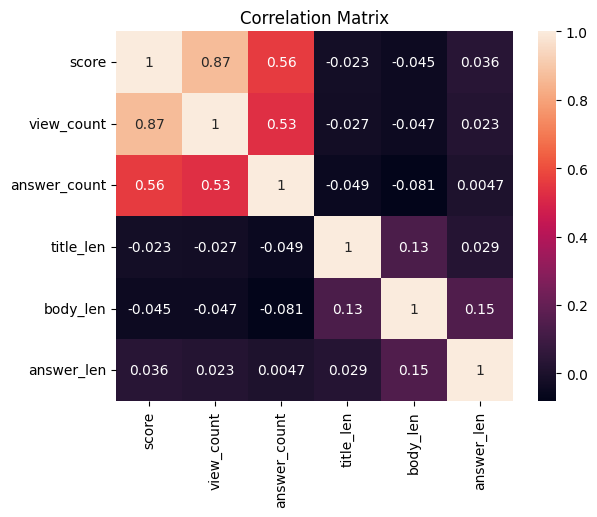

In [ ]:
# Add text length features
statistic_data['title_len'] = statistic_data['title'].str.len()
statistic_data['body_len'] = statistic_data['body'].str.len()
statistic_data['answer_len'] = statistic_data['answer_body'].str.len()

# Display correlation heatmap
sns.heatmap(statistic_data[['score', 'view_count', 'answer_count','title_len', 'body_len', 'answer_len']].corr(), annot=True)
plt.title("Correlation Matrix")
plt.show()

The correlation matrix shows that score, view_count, and answer_count are strongly related to each other, indicating that popular posts tend to be reflected across these metrics. In contrast, features like title length, body length, and answer length show weak correlations with engagement, indicating that the text's length has little impact to the popularity or success.

From these result, although the score, view_count, and answer_count appear to be important indicator for identifying popular posts that could be used to indicate post with more credible answer, we decided not to use them as features due to their significantly high variance. In addition, these metrics also accumulated overtime, meaning that older posts naturally have higher values regardless of the quality, which may affect fairness. Thus, we will be focusing on the linguistic feature to perform the text classification.

### Analysis by Tags

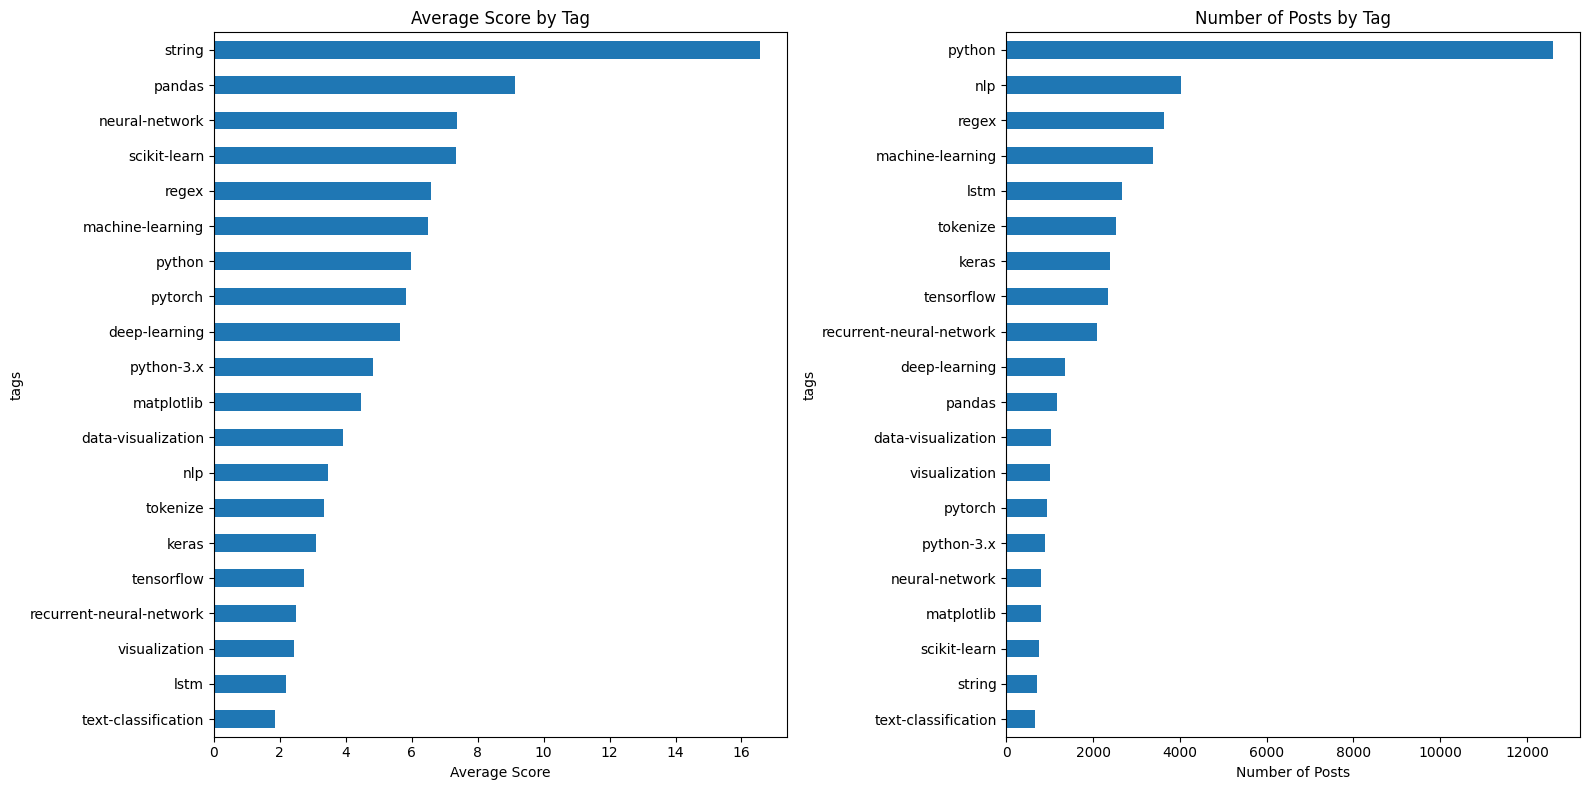

In [43]:
# Explode tags into rows
df_tagged = statistic_data.explode('tags')

# Calculate average score by tag
top_tags = df_tagged['tags'].value_counts().head(20)
tag_scores = df_tagged[df_tagged['tags'].isin(top_tags.index)].groupby('tags')['score'].mean().sort_values()

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot 1: Average score by tag
tag_scores.plot(kind='barh', ax=axes[0])
axes[0].set_title("Average Score by Tag")
axes[0].set_xlabel("Average Score")

# Plot 2: Number of posts by tag
top_tags.sort_values().plot(kind='barh', ax=axes[1])
axes[1].set_title("Number of Posts by Tag")
axes[1].set_xlabel("Number of Posts")

plt.tight_layout()
plt.show()

From the plots, we found that general tags like 'python', 'pandas', and 'string' tend to get higher average scores. This indicates that questions with widely applicable or foundational topics often receive more useful solution for developers and attract more attention. On the other hand, specialized tags like 'lstm', 'tokenize', and 'text-classification' are less common and usually score lower.

Although our data collection focuses on posts tagged with ‘nlp’ tag, we found that tagswith the highest number of post is 'pyhton'. The 'nlp' tag ranks second, with a significant difference compared to ‘python’ tag.

However, it also important to note that each post in Stack Overflow has more than one tag, ranging from general to more specific core concepts tags. Since 'python' is a broader tag,  thus, 'python' is likely to accompany almost every other tags, as it forms the foundation of most problems. Apart from that, we can observe that there are some tags that may not always be directly related to NLP topics such as 'machine-learning', 'deep-learning', and 'data-visualization'. This point will be taken into account in the following part.


### Time-based Trends

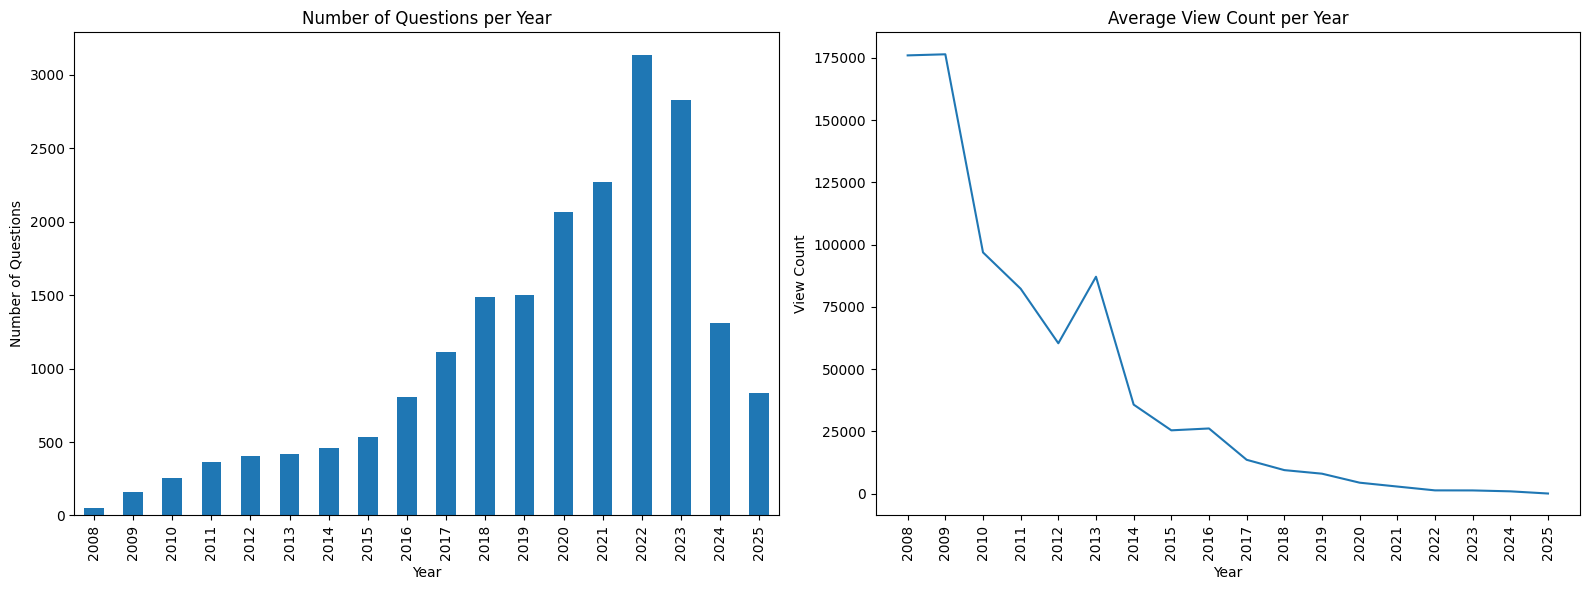

In [45]:
# Extract year from creation_date
statistic_data['year'] = statistic_data['creation_date'].dt.year

# Calculate number of questions and average view count
questions_per_year = statistic_data['year'].value_counts().sort_index()
avg_view_per_year = statistic_data.groupby('year')['view_count'].mean()

# Get list of years for consistent x-ticks
years = sorted(statistic_data['year'].unique())

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Number of questions over the year
questions_per_year.plot(kind='bar', ax=axes[0])
axes[0].set_title("Number of Questions per Year")
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Number of Questions")
axes[0].set_xticks(range(len(years)))
axes[0].set_xticklabels(years, rotation=90)

# Plot 2: Average of view count over the year
avg_view_per_year.plot(ax=axes[1])
axes[1].set_title("Average View Count per Year")
axes[1].set_xlabel("Year")
axes[1].set_ylabel("View Count")
axes[1].set_xticks(years)
axes[1].set_xticklabels(years, rotation=90)

plt.tight_layout()
plt.show()

From both plots we found this observations:

1. Increasing Number of Questions: Over time, the total number of questions asked each year has been increasing having the highest number in 2022 with over 3,000 questions. However, in 2023, there was a noticeable decline where the number of questions continued to decrease until 2025.

2. Declining Average View Count: On the other hand, the average view count per question has been significantly decreasing, from 2008 to 2025. The number have dropped significantly, especially in the more recent years.

These trends indicates that the number of developers using Stack Overflow to share their problems has been increasing, shows by the high number of questions. However, the number of developers using Stack Overflow to find their answer has been has decreases (decline in engagement) from the low number view counts. This also shows that, as engagement declines, the more recent answers collected in our system might not be the best option, as they may not have sufficient community validation.

# 2. Data Preprocessing

In this part, we will perform data preprocessing on the collected data. This step is important to eliminate noisy character and ensure our text consisst of the semanticlly meaningful words that will be useful to obtian better result in our classification. For our system, we will apply four preprocessing techniques:
1. Regex cleaning
2. Lowercasing
3. Lemmatisation
4. Stopword removal

In the following code, we will apply multiple combinations of these preprocessing techniques. This will allow us to evaluate which techniques are most effective for our classification. Furthermore, we also will implement preprocessing to three text columns that is the title (`title`), the question (`body`), and the concatenation of the title and question (`title_body`). We will also evaluate this component determine which part of the post is most effective for accurate classification.

In [ ]:
# Define function to perform text preprocessing and categorise ratings
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import spacy

stop_words = set(stopwords.words('english'))
nlp = spacy.load('en_core_web_sm', disable=["parser", "ner", "textcat"])
nlp.max_length = 5_000_000  # Increase the maximum allowed text length for lemmatisation

# Function to remove unnecessary characters, tags, and links
def regex_text(text):

    # Replace newline characters (\n) with spaces
    text = re.sub(r'\n', ' ', text)

    # Remove "https://" URLs in the text
    text = re.sub(r'https?://\S+', '', text)

    # Remove double quote in the text
    text = re.sub(r'&quot;', '', text)

    # Remove code block: <pre...><code>...</code></pre> including the content inside
    text = re.sub(r'<pre.*?><code>.*?</code></pre>', '', text)

    # Remove text tags while preserving the content inside
    text = re.sub(r'</?.*?>', '', text)

    # Remove any non-alphanumeric characters by keeping only letters, numbers, and spaces using regex
    text = re.sub(r'[^a-zA-Z0-9 ]', '', text)

    return text

# Function to preprocess text, optionally apply regex, remove stopwords, apply lemmatisation and lowercasing (Accept text or tokenized input)
def text_preprocessing(text, regex=False, remove_stop_word=False, lemmatisation=False, lower_case=False, input_tokens=False, return_tokens=False):

    # Apply regex
    if regex:
        text = regex_text(text)

    # Lowercasing
    if lower_case:
        text = text.lower()

    # Tokenize the text
    if not input_tokens:
        tokens = word_tokenize(text)
    else:
        tokens = text

    # Remove stopwords
    if remove_stop_word:
        tokens = [word for word in tokens if word not in stop_words]
        text = " ".join(tokens)

    # Lemmatisation
    if lemmatisation:
        doc = nlp(text)
        tokens = [token.lemma_ for token in doc]

    # Return the cleaned text or tokens
    if return_tokens:
        return tokens
    else:
        return " ".join(tokens)


Below, we also demonstrate the results of the preprocessing before applying it to the entire dataset. We can see that each technique succesfully works as expected:
1. **Regex cleaning**: Removes HTML tags and code block. In here, the `<p>` and `<code>` tags are removed, and the content within code block also removed.
2. **Lowercasing**: Converts text to lowercase. In here, the 'Currently' becomes 'currently'.
3. **Lemmatisation**: Normalise word into their base form. In here, 'showing' becomes 'show'.
4. **Stopword removal**: Removed low semantic word in the text. In here, the word 'it's' and 'I' are removed.

In [ ]:
# DEMONSTRATION
print("BEFORE PRE-PROCESSING:")
print(tidy_posts_df["body"][0])

print("\nAFTER PRE-PROCESSING:")
print(text_preprocessing(tidy_posts_df["body"][0], regex=True, remove_stop_word=True, lemmatisation=True, lower_case=True))

BEFORE PRE-PROCESSING:
<p>I am using the <strong>DateTimePicker</strong> control of <strong>MahApps</strong>. 
</p>

<pre><code>&lt;controls:DateTimePicker 
    SelectedDate="{Binding SelectedDateTime, RelativeSource={RelativeSource AncestorType=UserControl}}" 
    SelectedTimeFormat="Short" 
    SelectedDateFormat="Short"
    Culture="en-In"/&gt;
</code></pre>

<p>Currently it's showing datetime in <code>dd-mm-yyyy HH:mm</code> format.But I need to show that in <code>yyyy-mm-dd HH:mm Z</code> format. I see currently it has no property which takes datetime format as string pattern. <strong>So how to do this?</strong> </p>


AFTER PRE-PROCESSING:
use datetimepicker control mahapps currently show datetime ddmmyyyy hhmm formatbut need show yyyymmdd hhmm z format see currently property take datetime format string pattern


In [ ]:
# Implement pre-processing to the dataset

# Convert tags value from list into string
tidy_posts_df.loc[:, "tags"] = tidy_posts_df["tags"].apply(lambda x: " ".join(x))

# Concat the title with question body
tidy_posts_df["title_body"] = tidy_posts_df["title"] + " " + tidy_posts_df["body"]

# Define new columns to saved the pre-processing result
original_var = ["title", "body", "title_body"]

# Using different combination of pre-processing process
for var in original_var:
    tidy_posts_df[var+"_regex"] = tidy_posts_df[var].copy().apply(lambda x: text_preprocessing(x, regex=True, remove_stop_word=False, lemmatisation=False, lower_case=False))
    tidy_posts_df[var+"_lowercase"] = tidy_posts_df[var].copy().apply(lambda x: text_preprocessing(x, regex=False, remove_stop_word=False, lemmatisation=False, lower_case=True))
    tidy_posts_df[var+"_lemma"] = tidy_posts_df[var].copy().apply(lambda x: text_preprocessing(x, regex=False, remove_stop_word=False, lemmatisation=True, lower_case=False))
    tidy_posts_df[var+"_stopword"] = tidy_posts_df[var].copy().apply(lambda x: text_preprocessing(x, regex=False, remove_stop_word=True, lemmatisation=False, lower_case=False))

for var in original_var:
    tidy_posts_df[var+"_regex_lowercase"] = tidy_posts_df[var+"_regex"].copy().apply(lambda x: text_preprocessing(x, regex=False, remove_stop_word=False, lemmatisation=False, lower_case=True))
    tidy_posts_df[var+"_regex_lowercase_lemma"] = tidy_posts_df[var+"_regex_lowercase"].copy().apply(lambda x: text_preprocessing(x, regex=False, remove_stop_word=False, lemmatisation=True, lower_case=False))
    tidy_posts_df[var+"_regex_lowercase_stopword"] = tidy_posts_df[var+"_regex_lowercase"].copy().apply(lambda x: text_preprocessing(x, regex=False, remove_stop_word=True, lemmatisation=False, lower_case=False))
    tidy_posts_df[var+"_regex_lowercase_lemma_stopword"] = tidy_posts_df[var+"_regex_lowercase_lemma"].copy().apply(lambda x: text_preprocessing(x, regex=False, remove_stop_word=True, lemmatisation=False, lower_case=False))

tidy_posts_df[["title", "body", "title_regex_lowercase_lemma_stopword", "body_regex_lowercase_lemma_stopword"]]

title  \
0          MahApps DateTimePicker custom datetime format   
1      Merging or Combining two onEdit trigger functions   
2      How can I use multiple refs for an array of el...   
3      Bookmarklet in JavaScript to toggle Gmail conv...   
4      When data arrives before calling the STM32G4 U...   
...                                                  ...   
19995     Linear Regression problem in predicting values   
19996  How to call loaded Tensorflow model with custo...   
19997   How to make a prediction using karas TensorFlow?   
19998            Adapt Tortoise-TTS for another language   
19999  Tensorflow: Shape of 3D tensor (of an image) i...   

                                                    body  \
0      <p>I am using the <strong>DateTimePicker</stro...   
1      <p>I have script for Google Sheets that I coll...   
2      <p>As far as I understood I can use refs for a...   
3      <p>I want a bookmarklet to quickly toggle the ...   
4      <p>Data reception is locked if data arrives be...   
...                                                  ...   
19995  <p>I am trying to predict values using linear ...   
19996  <p>I've been following the <a href="https://ww...   
19997  <p>Ive coded this machine learning algoritm bu...   
19998  <p>I watched a YouTube video about voice cloni...   
19999  <p>I am following <a href="https://www.tensorf...   

                    title_regex_lowercase_lemma_stopword  \
0          mahapps datetimepicker custom datetime format   
1              merge combine two onedit trigger function   
2                    use multiple ref array element hook   
3      bookmarklet javascript toggle gmail conversati...   
4        datum arrive call stm32g4 uart receive function   
...                                                  ...   
19995            linear regression problem predict value   
19996  call load tensorflow model custom param call m...   
19997               make prediction use karas tensorflow   
19998                  adapt tortoisett another language   
19999       tensorflow shape 3d tensor image filter none   

                     body_regex_lowercase_lemma_stopword  
0      use datetimepicker control mahapps currently s...  
1      script google sheet collect interwebs get help...  
2      far understand use ref single element like imp...  
3      want bookmarklet quickly toggle gmail conversa...  
4      data reception lock datum arrive stm32 uart re...  
...                                                  ...  
19995  try predict value use linear regression use po...  
19996  I ve follow tensorflow text generation tutoria...  
19997  I ve code machine learning algoritm reture wie...  
19998  watch youtube video voice clone interesting to...  
19999  follow tutorial tensorfloworg folder image two...  

[20000 rows x 4 columns]

# 3.	Graphical representation of the dataset

In this part, we want to gain better understanding of the text before creating the classification by exploring the text in our data using visualisations. As mentioned before, we want to experiment with three text columns that is `title`, `body`, and `title_body`. Thus, we will generate visulations for these columns.

### Word cloud

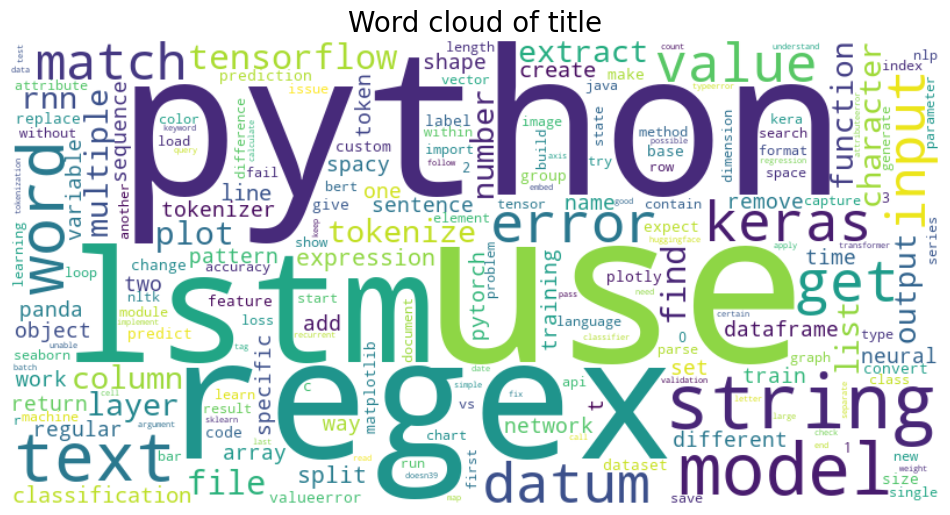

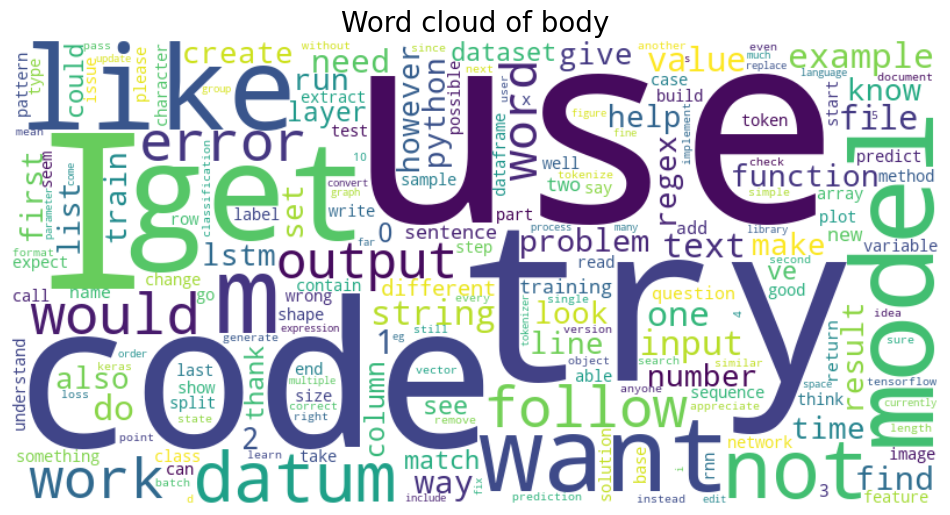

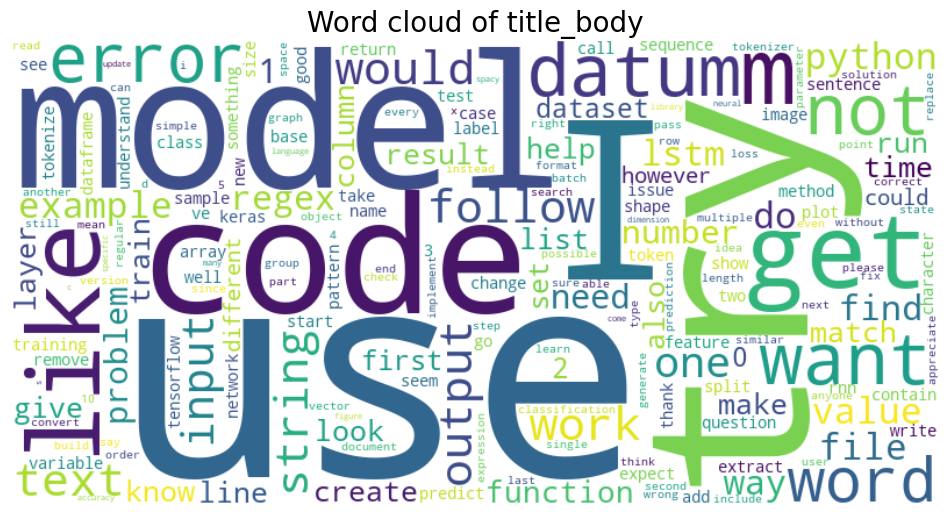

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

# 1. Function to generate word cloud to visualise the most frequent words
def plot_worldcloud(data, feature, num_remove = 0):

    whole_text = " ".join(data[feature])

    # Count word frequencies
    word_freq = Counter(whole_text.split())

    # Remove the top most common words (optional)
    most_common = word_freq.most_common(num_remove)
    for word, _ in most_common:
        del word_freq[word]

    wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
    plt.figure(figsize=(12, 8))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f'Word cloud of {feature.replace("_regex_lowercase_lemma_stopword", "")}', fontsize=20)
    plt.axis('off')
    plt.show()

# Generate word cloud
plot_worldcloud(tidy_posts_df, "title_regex_lowercase_lemma_stopword")
plot_worldcloud(tidy_posts_df, "body_regex_lowercase_lemma_stopword")
plot_worldcloud(tidy_posts_df, "title_body_regex_lowercase_lemma_stopword")

From the word cloud, it is apparent that the `title` column contains more meaningful words with high requency. For example, words like 'lstm', 'regex', and 'string' appear frequently and reflect the core topics of the posts. However, `body` and `title_body` contains more noise that can be seen from the frequent occurence of more general and less meaningful words, such as 'use', 'try', 'code', and 'model. This indicates that the `title` column offers concise summary of the post that will be powerful for our text classification.

### Word frequency

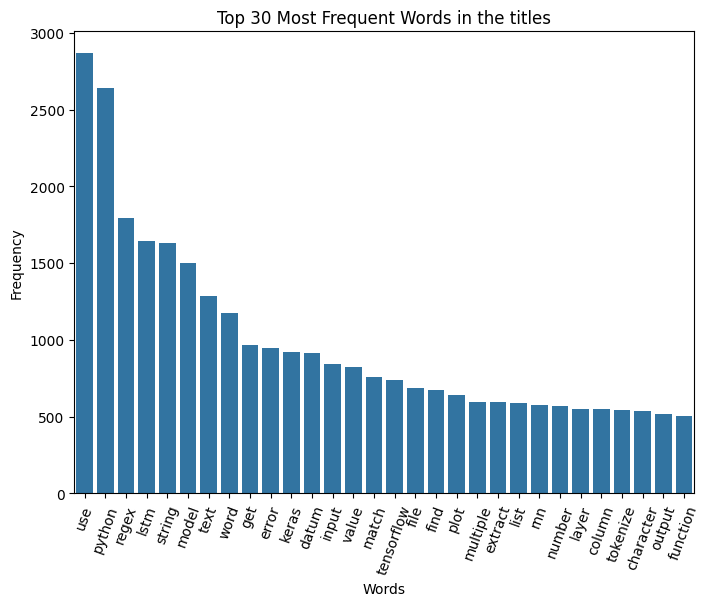

In [ ]:
from collections import Counter
import nltk
import seaborn as sns
from nltk.tokenize import word_tokenize

# 2. Plot the top N most frequent words in the text
token_series = tidy_posts_df['title_regex_lowercase_lemma_stopword'].copy()
token_series = token_series.apply(lambda x: word_tokenize(x))

# Count word frequencies
all_tokens = [token for tokens in token_series for token in tokens]
counter = Counter(all_tokens)

# Remove the top most common words
for word, _ in counter.most_common(0):
    del counter[word]

most_com = 30
plt.figure(figsize=(8, 6))
sns.barplot(x=[word for word, _ in counter.most_common(most_com)],
             y=[count for _, count in counter.most_common(most_com)])
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=70)
plt.title(f'Top {most_com} Most Frequent Words in the titles')
plt.show()


Here, we display the bar chart of word frequency from the `title` column to further support our argument. Although some of the high frequency words may be less meaningful, many represent technical terms related to the core problems described in the posts. These terms are valuable for task-based categorization. With this technical terms suck as 'regex'. 'string', 'keras', 'tensorflow', and 'tokenize, we could easily categorise our data based on the NLP tasks using `title`.

# 4.	Categorisation of the posts

In this section, we begin the process of classifying Stack Overflow posts into categories to improve navigation and accesibility. Since we have a large dataset, we aim to create a custom categorisation using our own category dictionary. Our goal is to build a system that consistenly categorizes posts around NLP tasks, as we observed that the tags on Stack Overflow often mix task and library name. By focusing on tasks, we also align more closely with how developers typically follow a sequence of steps when working on language modeling project. Thus, this approach improves efficiency and clarity of insights.

To define our custom categories, we build a dictionary where each task label is a key, and the associated keywords related to the task are the values. This gives us more control over the category separation that ensure alignment with our objectives and offers easier interpretability.

To better understand the semantic relationship within our text data, we also utilise BERTopic to generate cluster of semantically similar texts, which can be implemented with a simple line of code. BERTopic generates topic representations that has the ability of semantic understanding through the use of an embedding component to produce meaningful topics understandable to a human (Axelborn & Berggren 2023, p. 27). Although BERTopic assumes that each document only contains a single topic, which does not reflect the reality that documents may contain multiple topics, this aligns with our needs as we intend to assign each post to a single dominant category. It has no limitation on how large datasets it can handle, and has been shown to achieve competitive performance compared to other state-of-the-art topic modeling algorithms, such as LDA (Axelborn & Berggren 2023, p. 40), making it suitable for our system, especially since we are working with a large data with long texts.

This approach allowed us to explore the latent structure of our dataset and provides insights into contextual similarities across documnets. The result from BERTopic will be used as a reference point for us to manually define our category dictionary and also to evaluate whether the separation based on task is suitable for our data.

## BERTopic to initialise our own category

In [ ]:
from bertopic import BERTopic

# Your list of post titles
documents = tidy_posts_df["title_regex_lowercase_lemma_stopword"].copy().tolist()

# Create BERTopic model
topic_model = BERTopic()

# Fit the model to your text data
topics, probs = topic_model.fit_transform(documents)

# Inspect the top topics
topic_model.get_topic_info()[1:]

Topic  Count                                            Name  \
1        0    400                    0_panda_dataframe_column_row   
2        1    218               1_regex_regular_expression_python   
3        2    214             2_bert_embedding_bertopic_bertmodel   
4        3    192             3_replace_substre_resub_replacement   
5        4    191  4_stringtokenizer_tokenize_delimiter_tokenizer   
..     ...    ...                                             ...   
294    293     10               293_colorbar_dfplotbarh_color_bar   
295    294     10                   294_form_jquery_weired_drupal   
296    295     10      295_stringregex_python38_data39s_paragraph   
297    296     10                 296_dob_significant_ne_contract   
298    297     10   297_translate_translation_translating_english   

                                        Representation  \
1    [panda, dataframe, column, row, df, replace, v...   
2    [regex, regular, expression, python, match, pa...   
3    [bert, embedding, bertopic, bertmodel, finetun...   
4    [replace, substre, resub, replacement, substri...   
5    [stringtokenizer, tokenize, delimiter, tokeniz...   
..                                                 ...   
294  [colorbar, dfplotbarh, color, bar, barplot, pc...   
295  [form, jquery, weired, drupal, datalist, addev...   
296  [stringregex, python38, data39s, paragraph, el...   
297  [dob, significant, ne, contract, fulltext, pro...   
298  [translate, translation, translating, english,...   

                                   Representative_Docs  
1    [use replace text use regex panda dataframe, g...  
2    [python regular expression 1, use regular expr...  
3    [bert sentence embedding, bert get sentence em...  
4    [python regular expression resub replace match...  
5    [string tokenizer delimiter, java tokenize str...  
..                                                 ...  
294  [get bokeh colorbar show min max value, colorb...  
295  [display master detail form together, jquery f...  
296  [stringregex search excel python issue, use re...  
297  [gate extract ne document german, extract spec...  
298  [translator googletran translate text english,...  

[298 rows x 5 columns]

In [ ]:
# Visualize the topic separation
topic_model.visualize_topics()

The result shows a high number of categories. To easily interpret the result, we will also evaluate the reduced result with 20 topics.

In [ ]:
# Reduced the number of topics
topic_model_reduced = topic_model.reduce_topics(documents, nr_topics=20)

# Display the result
topic_df = topic_model_reduced.get_topic_info()
topic_df

Topic  Count                                        Name  \
0      -1   8585                    -1_use_python_lstm_model   
1       0   4269                 0_regex_string_python_match   
2       1   3097                    1_lstm_keras_model_input   
3       2   1491             2_bert_word_text_classification   
4       3   1077            3_plot_matplotlib_seaborn_plotly   
5       4    365      4_attribute_attributeerror_object_name   
6       5    184          5_huggingface_transformer_face_hug   
7       6    166        6_strtok_type_typescript_constructor   
8       7    154            7_autocomplete_material_ui_react   
9       8    130         8_spring_authentication_jax_request   
10      9    117       9_azure_pipeline_powershell_sagemaker   
11     10     97              10_git_docker_container_github   
12     11     54               11_flutter_swiftui_widget_app   
13     12     44                  12_nextjs_react_vue_native   
14     13     39                    13_expect_mock_test_jest   
15     14     38                14_medium_css_tailwind_query   
16     15     35                   15_mongodb_query_sql_join   
17     16     32                    16_thread_hang_call_play   
18     17     15           17_laravel_cms_phpmyadmin_symfony   
19     18     11  18_subsonic_simplerepository_30_connection   

                                       Representation  \
0   [use, python, lstm, model, string, keras, text...   
1   [regex, string, python, match, tokenize, use, ...   
2   [lstm, keras, model, input, tensorflow, layer,...   
3   [bert, word, text, classification, word2vec, s...   
4   [plot, matplotlib, seaborn, plotly, chart, bar...   
5   [attribute, attributeerror, object, name, modu...   
6   [huggingface, transformer, face, hug, model, t...   
7   [strtok, type, typescript, constructor, functi...   
8   [autocomplete, material, ui, react, component,...   
9   [spring, authentication, jax, request, certifi...   
10  [azure, pipeline, powershell, sagemaker, devop...   
11  [git, docker, container, github, dockercompose...   
12  [flutter, swiftui, widget, app, view, swift, b...   
13  [nextjs, react, vue, native, vuejs, page, vite...   
14  [expect, mock, test, jest, testing, result, wo...   
15  [medium, css, tailwind, query, tailwindcss, me...   
16  [mongodb, query, sql, join, update, table, rec...   
17  [thread, hang, call, play, execution, ringtone...   
18  [laravel, cms, phpmyadmin, symfony, web, host,...   
19  [subsonic, simplerepository, 30, connection, r...   

                                  Representative_Docs  
0   [use python separate line text use pattern mat...  
1   [split string base multiple regex match, pytho...  
2   [lstm model valueerror input 0 layer lstm inco...  
3   [use text classification dataframe python, tex...  
4   [line plot seaborn, plot bar chart python, add...  
5   [attributeerror object attribute 39outputtenso...  
6   [use transformer huggingface without tokenizat...  
7   [tokenize string without use strtok, use strto...  
8   [material ui autocomplete custom value, get va...  
9   [customize spring boot error response code wit...  
10  [template error yaml pipeline azure devop, azu...  
11  [splitting commit git, need run multiple conta...  
12  [error import opencv module flutter, flutter s...  
13  [deploy nextjs app without nodejs server, diff...  
14  [get expect regex expression, python regex ret...  
15  [target css ipad exclude safari 4 desktop use ...  
16  [parse complex query sql, find colon separate ...  
17  [java 21 virtual thread address main reason sw...  
18  [homestead laravel call prestashop host machin...  
19  [use subsonic 30 simplerepository exist databa...

From the reduced BERTopic results, we observed thatsome of the topic combine task and tool/library names (`1_lstm_keras_model_input`), which support our understanding that most posts have mixed tags. Although, we can see there is topic that very specific to library names (`5_huggingface_transformer_face_hug`), more of the topic are broader and more closely related to NLP tasks (`0_regex_string_python_match`, `2_bert_word_text_classification`, and `3_plot_matplotlib_seaborn_plotly`). Some of the other topic are not related to NLP tasks, which shows that our data also contains noises from unrelated NLP topic. But, we can see that the number of posts falling under the NLP-related topic is larger. Therefore, we will use the more detailed output to construct the keyword for our dictionary, which will be provided in the report.

## Define Category Dictionary

After observing the result from BERTopic, we come up with 12 categories to classify the text based on NLP tasks. From there, we collected keywords that related to the category based on our domain knowledge, as well as terms that are semantically similar to those keywords. We compiled all relevant keywords and selected the **top 10 keywords** with the highest occurrence in our text.

We choose this approach to ensure consistent and fair comparison between categories. By using the same number of keywords per category, we aim to maintain balanced semantic richness and ensure clear separation between keywords. This helps avoid redundancy in meaning between categories that supports better interpretability and separation. It also reduces the chances of overlooking important keywords that might otherwise be forgotten.

Later, we want to categorise our data using this dictionary with two models that is **rule-based method** and **cosine similarity using embeddings**. In the rule-based method, having a constant number of keywords simplifies intrepert and to avoids potential of another categories having more keywords matches that could result in bias. Similarly, for the embedding based approach, we want to avoid prevent excessive semantic signal that could lead to length-based bias where longer strings might have denser semantic representation because it provides more context.

In [ ]:
category_dict = {
    'preprocessing': ['regex', 'string',  'expression', 'match',  'pattern', 'replace', 'resub', 'substring', 'substitute', 'stringreplace', 'regexsplit', 'regexmatching', 'matching', 'space', 'white', 'character', 'alphanumeric', 'whitespace', 'separator', 'uppercase', 'lowercase', 'capitalize', 'punctuation'],
    'tokenisation': ['tokenize', 'delimiter', 'tokenizer', 'token',  'tokeninput', 'tokenlist', 'tokenization', 'ngram', 'bigram', 'streamtokenizer', 'regextokenizer', 'punkt', 'wordtokenize'],
    'normalisation': ['lemmatization', 'lemma', 'lemmatizer', 'lemmatize', 'stem', 'spacy', 'stanford', 'corenlp', 'stanfordnlp', 'nltk', 'wordnet', 'stopword', 'stopwords', 'stop', 'remove', 'filterstopword', 'removestopwords', 'stopwordremoval', 'textcleaning'],
    'syntatic_annotation': ['pos','tag','tagger','wordpos', 'noun', 'subject', 'adjective', 'nounverbnoun', 'markov', 'tagging', 'entity','recognition', 'ner', 'namedentity', 'entityrecognizer', 'person', 'organization', 'location', 'dependency', 'parser'],
    'vectorisation': ['tfidf', 'tf', 'tfidfvectorizer', 'vector', 'countvectorizer', 'vectorize', 'vectorization', 'bow', 'bagofword', 'bag', 'sparse'],
    'embedding': ['bert', 'embedding',  'embed', 'dense', 'word2vec', 'vector', 'cbow', 'bidirectional', 'bidirection', 'embeddings', 'fasttext'],
    'deep_neural_network': ['rnn', 'rnncell', 'lstm', 'lstmrnn', 'bidirectional', 'bidirection', 'gru', 'attention', 'layers', 'layer', 'recurrent', 'lstminput', 'hug', 'face', 'hugging', 'huggingface', 'transformer', 'weights', 'tensorflow', 'tensor', 'pytorch', 'keras', 'seqtoseq', 'seq2seq', 'descent', 'gradient', 'huggingfacetransformer', 'softmax', 'sigmoid', 'activation', 'tanh', 'relu', 'gradient', 'descent'],
    'machine_learning': ['forest', 'random', 'decision', 'tree', 'scikitlearn', 'scikit', 'sklearn', 'logistic', 'svm', 'naive', 'bayes', 'cluster', 'kmean', 'pca', 'elbow', 'kmeans', 'gridsearchcv', 'grid', 'crossvalidation', 'cross', 'kfold', 'validation', 'sklearn', 'linear', 'regression', 'textblob', 'linearsvc'],
    'topic_modeling_question_answering': ['lda', 'gensim', 'bertopic', 'topic', 'topicmodeling', 'latent', 'dirichlet', 'ldamodel', 'topicdistribution', 'nlptopic', 'gpt3', 'answer', 'gpt', 'prompt', 'question', 'gpt2', 'api', 'openai'],
    'evaluation': ['precision','roc', 'auc', 'f1score', 'score', 'recall', 'confusion', 'matrix', 'accuracy', 'metric', 'evaluation', 'evaluate'],
    'visualisation': ['wordcloud', 'cloud', 'visualize', 'seaborn', 'barplot', 'matplotlib', 'axis', 'tick', 'chart', 'plot']}

In [ ]:
import pandas as pd
from collections import Counter
from gensim import corpora

processed_texts = tidy_posts_df["title_regex_lowercase_lemma_stopword"].copy().tolist()

for i, text in enumerate(processed_texts):
    processed_texts[i] = processed_texts[i].split()

dictionary = corpora.Dictionary(processed_texts)
corpus = [dictionary.doc2bow(text) for text in processed_texts]

# Function to count keyword frequencies using doc2bow
def count_keywords_with_doc2bow(corpus, keyword_list, dictionary):
    keyword_count = Counter()

    # Iterate through the corpus and count occurrences of each keyword
    for doc in corpus:
        for word_id, word_count in doc:
            word = dictionary[word_id]
            if word in keyword_list:
                keyword_count[word] += word_count

    return keyword_count

# Create a dictionary to store keyword frequencies for each category
keyword_frequencies = {}

# Iterate through the dictionary to get counts for each category's keywords
for category, keywords in category_dict.items():
    category_freq = count_keywords_with_doc2bow(corpus, keywords, dictionary)
    keyword_frequencies[category] = category_freq

# Keep only 10 keywords with most frequency for each category
keyword_data = []

for category, freqs in keyword_frequencies.items():
    sorted_keywords = sorted(freqs.items(), key=lambda x: x[1], reverse=True)
    str_keywords = ', '.join(f"{keyword} ({count})" for keyword, count in sorted_keywords)
    keyword_data.append({'Category': category, 'Keywords': str_keywords})

keyword_df = pd.DataFrame(keyword_data)

keyword_df


Category  \
0                       preprocessing   
1                        tokenisation   
2                       normalisation   
3                 syntatic_annotation   
4                       vectorisation   
5                           embedding   
6                 deep_neural_network   
7                    machine_learning   
8   topic_modeling_question_answering   
9                          evaluation   
10                      visualisation   

                                             Keywords  
0   regex (1793), string (1634), match (757), char...  
1   tokenize (543), tokenizer (401), token (343), ...  
2   remove (412), spacy (387), nltk (198), stop (9...  
3   tag (125), entity (112), ner (71), recognition...  
4   vector (177), tfidf (42), countvectorizer (35)...  
5   bert (183), vector (177), embed (145), word2ve...  
6   lstm (1644), keras (923), tensorflow (737), rn...  
7   regression (128), validation (122), sklearn (1...  
8   api (159), gensim (91), question (62), topic (...  
9   accuracy (212), matrix (112), score (85), metr...  
10  plot (639), matplotlib (262), chart (206), sea...

Here, we define the final category dictionary with 10 keywords for each category that will be used for the following part.

In [ ]:
final_category_dict = {
    'preprocessing': ['regex', 'string', 'match', 'character', 'expression', 'pattern', 'replace', 'space', 'matching', 'substring'],
    'tokenisation': ['tokenize', 'tokenizer', 'token', 'tokenization', 'delimiter', 'ngram', 'bigram', 'wordtokenize', 'streamtokenizer', 'punkt'],
    'normalisation': ['remove', 'spacy', 'nltk', 'stop', 'stanford', 'stopword', 'stem', 'lemmatization', 'corenlp', 'wordnet'],
    'syntatic_annotation': ['tag', 'entity', 'ner', 'recognition', 'parser', 'dependency', 'noun', 'pos', 'location', 'adjective'],
    'vectorisation': ['vector', 'tfidf', 'countvectorizer', 'tf', 'tfidfvectorizer', 'sparse', 'bag', 'vectorize', 'vectorization', 'bow'],
    'embedding': ['bert', 'vector', 'embed', 'word2vec', 'embedding', 'bidirectional', 'fasttext', 'dense', 'cbow', 'embeddings'],
    'deep_neural_network':['lstm', 'keras', 'tensorflow', 'rnn', 'layer', 'pytorch', 'tensor', 'huggingface', 'transformer', 'recurrent'],
    'machine_learning': ['regression', 'validation', 'sklearn', 'scikitlearn', 'tree', 'random', 'cluster', 'linear', 'decision', 'forest'],
    'topic_modeling_question_answering': ['api', 'gensim', 'question', 'topic', 'answer', 'gpt2', 'openai', 'lda', 'prompt', 'gpt3'],
    'evaluation': ['accuracy', 'matrix', 'score', 'metric', 'confusion', 'evaluate', 'evaluation', 'precision', 'recall', 'roc'],
    'visualisation': ['plot', 'matplotlib', 'chart', 'seaborn', 'axis', 'visualize', 'tick', 'cloud', 'barplot', 'wordcloud']}

### 4.1. Rule-based Model

The rule-based model works by using our defined category and associated keywords. It operates on simple logic that is if a certain words appear in text that match the keywords, a score is assigned to the corresponding category. The category with the highest score is then used to label the text. If the text does not match any of the keywords, it is labeled as 'other'. Here, we compile the workflow of this model into a function called `rule_based_category` and present a demonstration of its implementation.

In [ ]:
### RULE-BASED METHOD

from nltk.tokenize import word_tokenize

# 1. Function to perform rule based categorisation
def rule_based_category(df, column, category_keywords):

    result_df = df.copy()

    text_categories = []

    for text in result_df[column]:
        tokens = word_tokenize(text)

        scores = {}

        # Count the matching keywords score
        for category, keywords in category_keywords.items():

            match_count = sum(token in keywords for token in tokens)

            if match_count > 0:
                scores[category] = match_count

        # Assign the label based on the count score
        if scores:
            predicted_category = max(scores, key=scores.get)
        else:
            predicted_category = 'other'

        text_categories.append(predicted_category)

    result_df['rule_based_category'] = text_categories

    return result_df


In [ ]:
# Implement the rule based categorisation to the data
rule_based_df = rule_based_category(tidy_posts_df, "title_regex_lowercase_lemma_stopword", final_category_dict)
rule_based_df[["title_regex_lowercase_lemma_stopword", "body_regex_lowercase_lemma_stopword", "rule_based_category"]].head(10)

title_regex_lowercase_lemma_stopword  \
0      mahapps datetimepicker custom datetime format   
1          merge combine two onedit trigger function   
2                use multiple ref array element hook   
3  bookmarklet javascript toggle gmail conversati...   
4    datum arrive call stm32g4 uart receive function   
5               jdbc resultset get column table alia   
6                                stanford nlp python   
7                    store image instead show server   
8             multiple hero share tag within subtree   
9                   measure code execution time code   

                 body_regex_lowercase_lemma_stopword  rule_based_category  
0  use datetimepicker control mahapps currently s...                other  
1  script google sheet collect interwebs get help...                other  
2  far understand use ref single element like imp...                other  
3  want bookmarklet quickly toggle gmail conversa...                other  
4  data reception lock datum arrive stm32 uart re...                other  
5  imagine query like maybe table column name tho...                other  
6  want find sentiment positivenegativeneutral gi...        normalisation  
7  run code find site server would like store ima...                other  
8  try navigate one screen another route hit butt...  syntatic_annotation  
9  want know much time procedurefunctionorder tak...                other

In [ ]:
# Evaluate the separation for each category from rule based
rule_based_count = rule_based_df["rule_based_category"].value_counts()
rule_based_count

rule_based_category
other                                7668
preprocessing                        3953
deep_neural_network                  3496
visualisation                        1145
tokenisation                         1039
normalisation                         668
machine_learning                      485
embedding                             457
syntatic_annotation                   307
evaluation                            275
topic_modeling_question_answering     270
vectorisation                         237
Name: count, dtype: int64

### 4.2 Cosine Similarity with Sentence BERT Embeddings

The cosine similarity model starts with converting the text and category dictionary into embeddings. Each post is transformed into an embedding vector, and the keywords of each category are concatenated into a signle sentence string and then embedded as well. The embedding vector of the text is compared with each category's embedding vector using cosine similarity to determine which category is semantically closest to the text. In this project, we will experiment with generating embeddings using **sentence-transformer (SBERT)** and **CodeBERT**.

SBERT is a modification of BERT to improve performance on sentence similarity tasks. Standard BERT generates contextual embeddings for each token and requires comparing sentence pairs individually, which is computationally expensive and inefficient for large-scale similarity tasks (Axelborn & Berggren 2023, p. 13). SBERT addresses this limitation by using a Siamese network structure to produce fixed-size sentence embeddings that can be compared using cosine or Euclidean similarity. In our project, we use the SentenceTransformer library that provides implementations of SBERT and its variants. The `all-MiniLM-L6-v2` is a pre-trained transformer-based language model that has small size and offers strong performance compared to the other pre-trained transformer, which will be useful for our large dataset.

CodeBERT is a bimodal pre-trained model developed to support natural language and programming language understanding. It extends the BERT architecture and is trained on paired data of natural language (NL) and programming language (PL) from GitHub repositories (Feng et al. 2020, p. 1). This design allows CodeBERT to perform well on code-related tasks such as code search and code summarization (Feng et al. 2020, p. 8). As we know the posts text in Stack Overflow often contains programming texts (such as library names or code block) that SBERT may not be capture semantically. Thus, we also want to explore the performance of CodeBERT to embed our text.

Below, we evaluate the performance of each embedding to determine which is more suitable to our data.

In [ ]:
### COSINE SIMILARITY WITH EMBEDDINGS

from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
import torch
import numpy as np
import matplotlib.pyplot as plt
import time

# Load models
sentencebert_model = SentenceTransformer('all-MiniLM-L6-v2')

codebert_tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
codebert_model = AutoModel.from_pretrained("microsoft/codebert-base")

# 1. Function to generate embedding
def get_embedding(df, text, model_type='sbert', for_category=False, print_time=False):

    start_time = time.time()

    # Convert input to list
    if for_category:
        texts = [text] if isinstance(text, str) else text
    else:
        texts = df[text].tolist()

    # Generate embeddings for text
    if model_type == 'sbert':
        embeddings = sentencebert_model.encode(texts, convert_to_numpy=True)

    elif model_type == 'codebert':
        embeddings = []
        for text in texts:
            inputs = codebert_tokenizer(text, return_tensors="pt", padding=True, truncation=True)
            with torch.no_grad():
                outputs = codebert_model(**inputs)
            cls_embedding = outputs.last_hidden_state[:, 0, :]
            embeddings.append(cls_embedding.squeeze().numpy())

        embeddings = np.array(embeddings)

    else:
        raise ValueError("Model not identified")

    end_time = time.time()

    if print_time:
        print(f"Computation time to generate embedding: {end_time-start_time:.2f} seconds")

    return embeddings

# 2. Function to perform categorisation using cosine similarity between sentence embedding of data to each category
def cosine_similarity_sentence_embed(df, column, category_keywords, model_type='sbert', text_embeddings=None, print_plot=False):

    # Convert keywords to representative category sentences
    category_sentences = {cat: ' '.join(keywords) for cat, keywords in category_keywords.items()}

    # Calculate sentence embedding for each category
    category_embeddings = {category: get_embedding(df, sentence, model_type, True) for category, sentence in category_sentences.items()}

    best_categories = []
    best_scores = []
    similarities = {}

    # Calculate sentence embedding for the posts
    if text_embeddings is None:
        text_embeddings = get_embedding(df, column, model_type)

    # Classify each document
    for i, text_embedding in enumerate(text_embeddings):

        # Calculate the cosine similarity between sentence embeddings
        similarities[i] = {}
        for category, category_embedding in category_embeddings.items():

            similarity = cosine_similarity(np.atleast_2d(text_embedding), np.atleast_2d(category_embedding)).item()
            similarities[i][category] = similarity


        # Collect category with the highest cosine similarity
        best_category, best_score = max(similarities[i].items(), key=lambda x: x[1])

        best_categories.append(best_category)
        best_scores.append(best_score)

    # Evaluate the distribution to determine the threshold
    if print_plot:
        all_similarities = [similarity for doc_sim in similarities.values() for similarity in doc_sim.values()]
        plt.hist(all_similarities, bins=30, color='blue', alpha=0.7)
        plt.title('Cosine Similarity Distribution for ' + column)
        plt.xlabel('Cosine Similarity')
        plt.ylabel('Frequency')
        plt.show()

    return best_categories, best_scores

# 3. Function to assign category label for each text based on threshold
def assign_category_cosine_similarity(df, best_categories, best_scores, threshold=0.3):
    text_categories = []
    result_df = df.copy()

    # Assign category to each posts based on the threshold
    for i, score in enumerate(best_scores):
        if score < threshold:
            text_categories.append('other')
        else:
            text_categories.append(best_categories[i])

    result_df['cosine_category'] = text_categories

    return result_df

Computation time to generate embedding: 13.16 seconds


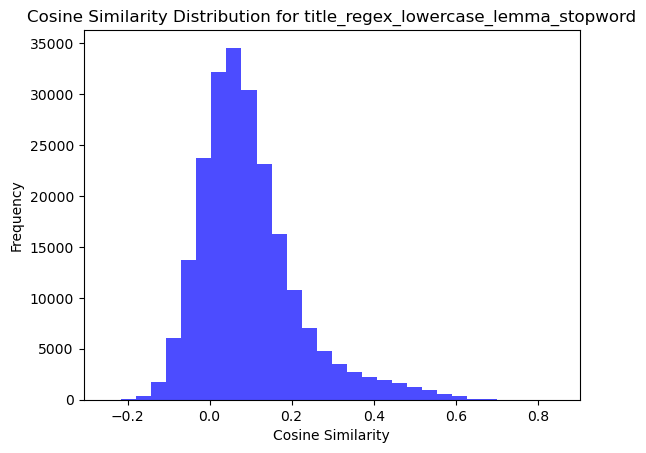

In [ ]:
# Implement the cosine similarity with sbert embeddings using the 'title' column
title_preprocessed_embedding_sbert = get_embedding(tidy_posts_df, "title_regex_lowercase_lemma_stopword", "sbert", False, True)
categories_sbert, scores_sbert = cosine_similarity_sentence_embed(tidy_posts_df, "title_regex_lowercase_lemma_stopword", final_category_dict, "sbert", title_preprocessed_embedding_sbert, True)

In [ ]:
cosine_sbert_df = assign_category_cosine_similarity(tidy_posts_df, categories_sbert, scores_sbert, 0.3)
cosine_sbert_df[['title_regex_lowercase_lemma_stopword','cosine_category']].head(10)

title_regex_lowercase_lemma_stopword cosine_category
0      mahapps datetimepicker custom datetime format           other
1          merge combine two onedit trigger function           other
2                use multiple ref array element hook           other
3  bookmarklet javascript toggle gmail conversati...           other
4    datum arrive call stm32g4 uart receive function           other
5               jdbc resultset get column table alia           other
6                                stanford nlp python   normalisation
7                    store image instead show server           other
8             multiple hero share tag within subtree           other
9                   measure code execution time code           other

In [ ]:
# Evaluate the separation for each category from cosine similarity of sentence embeddings
cosine_sbert_count = cosine_sbert_df["cosine_category"].value_counts()
cosine_sbert_count

cosine_category
other                                8633
deep_neural_network                  3337
preprocessing                        2818
tokenisation                         1534
visualisation                        1240
normalisation                         857
embedding                             517
syntatic_annotation                   318
machine_learning                      281
evaluation                            246
vectorisation                         134
topic_modeling_question_answering      85
Name: count, dtype: int64

Computation time to generate embedding: 1201.1 seconds


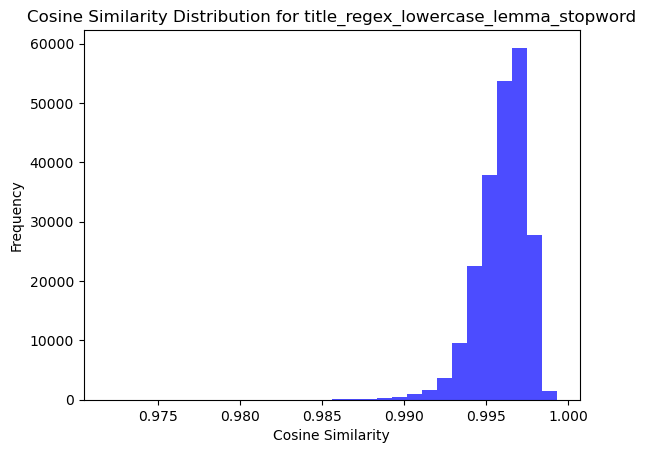

In [ ]:
# Implement the cosine similarity with codebert embeddings using the 'title' column
title_preprocessed_codebert_embedding = get_embedding(tidy_posts_df, "title_regex_lowercase_lemma_stopword", "codebert", False, True)
categories_codebert, scores_codebert = cosine_similarity_sentence_embed(tidy_posts_df, "title_regex_lowercase_lemma_stopword", final_category_dict, "codebert", title_preprocessed_codebert_embedding, True)

In [ ]:
cosine_codebert_df = assign_category_cosine_similarity(tidy_posts_df, categories_codebert, scores_codebert, 0.993)
cosine_codebert_df[['title_regex_lowercase_lemma_stopword','cosine_category']].head(10)

title_regex_lowercase_lemma_stopword  \
0      mahapps datetimepicker custom datetime format   
1          merge combine two onedit trigger function   
2                use multiple ref array element hook   
3  bookmarklet javascript toggle gmail conversati...   
4    datum arrive call stm32g4 uart receive function   
5               jdbc resultset get column table alia   
6                                stanford nlp python   
7                    store image instead show server   
8             multiple hero share tag within subtree   
9                   measure code execution time code   

                     cosine_category  
0                      preprocessing  
1                      preprocessing  
2                      preprocessing  
3                      preprocessing  
4  topic_modeling_question_answering  
5  topic_modeling_question_answering  
6                   machine_learning  
7                syntatic_annotation  
8                syntatic_annotation  
9                      preprocessing

In [ ]:
# Evaluate the separation for each category from cosine similarity of sentence embeddings
cosine_codebert_count = cosine_codebert_df["cosine_category"].value_counts()
cosine_codebert_count

cosine_category
preprocessing                        9904
embedding                            2677
normalisation                        2025
machine_learning                     2003
syntatic_annotation                  1546
deep_neural_network                   539
vectorisation                         414
topic_modeling_question_answering     396
visualisation                         334
evaluation                            130
other                                  30
tokenisation                            2
Name: count, dtype: int64

From the result between the SBERT and CodeBERT, it is apparent that CodeBERT embeddings produce almost perfect cosine similarities, which shows the CodeBERT embedding does not provide clear distinction between different text categories and possibly create embeddings that do not affectively differentiate between different concepts. SBERT provides better nuanced embeddings that are better to distinguish categories that is more useful to classification tasks. This can further be seen by the number of 'other' in CodeBERT result, which is significantly lower compared to SBERT, showing that CodeBERT create overly similar embeddings that cause incorrectly group dissimilar texts.

Other than that, we discovered that CodeBERT has a significantly longer computation time, approximately 91 times slower than the SBERT. Thus, as we also has a large size of data, we will proceed with using SBERT as our embeddings algorithm.

Following that, we want to evaluate the threshold between three text column that we want to explore that is `title`, `body`, and `title_body`.

Computation time to generate embedding: 1541.96 seconds


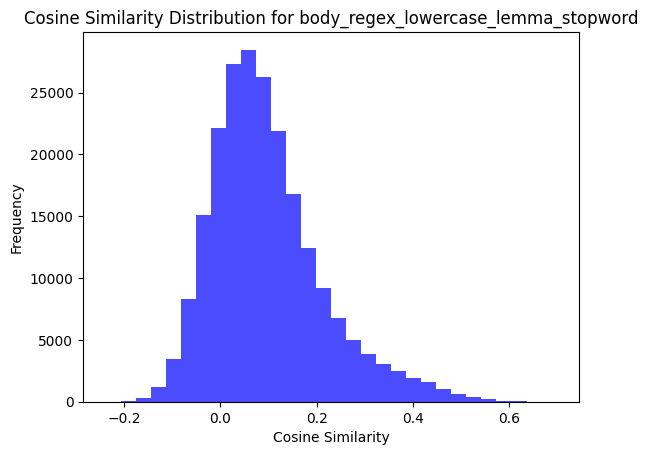

In [ ]:
body_preprocessed_embedding_sbert = get_embedding(tidy_posts_df, "body_regex_lowercase_lemma_stopword", "sbert", False, True)
body_categories_sbert, body_scores_sbert = cosine_similarity_sentence_embed(tidy_posts_df, "body_regex_lowercase_lemma_stopword", final_category_dict, "sbert", body_preprocessed_embedding_sbert, True)

Computation time to generate embedding: 1602.64 seconds


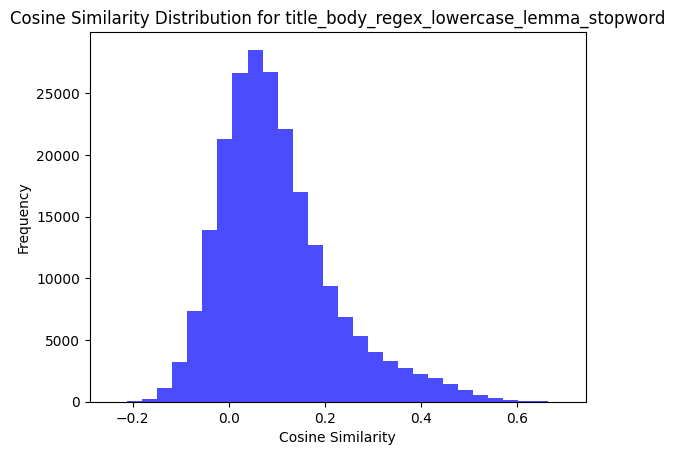

In [ ]:
title_body_preprocessed_embedding_sbert = get_embedding(tidy_posts_df, "title_body_regex_lowercase_lemma_stopword", "sbert", False, True)
title_body_categories_sbert, title_body_scores_sbert = cosine_similarity_sentence_embed(tidy_posts_df, "title_body_regex_lowercase_lemma_stopword", final_category_dict, "sbert", title_body_preprocessed_embedding_sbert, True)

Based on the results for three text columns, all distributions show similar right-skewed patterns with most values falling between -0.2 and 0.6, and most concentrated around 0.0-0.2 before tapering off after 0.3. Thus, we will use 0.3 as the threshold for labeling across the three columns, as it sits near the right tail of these distributions, where the frequency of values significantly decreased but before it completely tapers off. We can also observe that using 0.3 as the threshold creates a reasonable separation between likely matches and the "other" category, which aligns with our expectation that many posts contain tag combinations outside 'nlp' alone.

### 4.3 Model Evaluation

As our algorithm is unsupervised, we will use the **silhoutte score** for model evaluation along with **inter-cluster and intra-cluster distances** to provide additional assessment. Here, we apply the evaluation to the demonstration above to observe its implementation.

In [ ]:
### SILHOUTTE SCORE

from sentence_transformers import SentenceTransformer
from sklearn.metrics import silhouette_score

# 1. Function to calculate silhoutte score without considering 'other' label
def calculate_silhoutte_score(df, embeddings, label_col, print_result=False):
    mask = df[label_col] != 'other'
    score_without_other = silhouette_score(embeddings[mask], df[label_col][mask])

    if print_result:
        print(f"Silhouette score without 'other': {score_without_other:.3f}")
    else:
        return score_without_other


In [ ]:
# Creating Sentence embedding for title_regex_lowercase_lemma_stopword for fair evaluation calculation
evaluate_title_embedding = get_embedding(tidy_posts_df, "title_regex_lowercase_lemma_stopword", "sbert")

In [ ]:
# Evaluating the silhoutte score for both model
print("Rule-based model:")
calculate_silhoutte_score(rule_based_df, evaluate_title_embedding, 'rule_based_category', True)

print("\nCosine similarity with Sentence-BERT embedding model:")
calculate_silhoutte_score(cosine_sbert_df, evaluate_title_embedding, 'cosine_category', True)

Rule-based model:
Silhouette score without 'other': 0.064

Cosine similarity with Sentence-BERT embedding model:
Silhouette score without 'other': 0.091


In [ ]:
### INTRA AND INTER CLUSTER DISTANCE

from sklearn.metrics import pairwise_distances
from collections import defaultdict

# 1. Function to calculate intra and inter cluster distance
def compute_intra_inter_cluster_distances(df, embeddings, label_col, print_result=False):
    label_to_indices = defaultdict(list)

    # Filter out 'other' label
    valid_mask = df[label_col] != 'other'
    filtered_df = df[valid_mask]
    filtered_embeddings = embeddings[valid_mask.to_numpy()]

    # Group data point indices by cluster label
    for idx, label in enumerate(filtered_df[label_col]):
        label_to_indices[label].append(idx)

    cluster_centroids = {}
    intra_dists = []

    # Intra-cluster: Calculate distance between each points to its cluster centroid
    for label, indices in label_to_indices.items():
        cluster_points = filtered_embeddings[indices]
        centroid = np.mean(cluster_points, axis=0)
        cluster_centroids[label] = centroid

        dists = np.linalg.norm(cluster_points - centroid, axis=1)
        intra_dists.extend(dists)

    intra_dist = np.mean(intra_dists)

    # Inter-cluster: Calculate pairwise distances between all cluster centroids
    centroids = np.array(list(cluster_centroids.values()))
    if len(centroids) > 1:
        inter_dists = pairwise_distances(centroids)

        # Remove diagonal, which contain self distance
        inter_dists = inter_dists[np.triu_indices_from(inter_dists, k=1)]
        inter_dist = np.mean(inter_dists)
    else:
        # If there is only one cluster, making no pairwise calculation
        inter_dist = 0.0

    if print_result:
        print(f"Average Intra-cluster Distance: {intra_dist:.3f}")
        print(f"Average Inter-cluster Distance: {inter_dist:.3f}")
    else:
        return intra_dist, inter_dist

In [ ]:
# Evaluating the intra and inter cluster distance for both model
print("Rule-based model:")
compute_intra_inter_cluster_distances(rule_based_df, evaluate_title_embedding, 'rule_based_category', True)

print("\nCosine similarity with Sentence-BERT embedding model:")
compute_intra_inter_cluster_distances(cosine_sbert_df, evaluate_title_embedding, 'cosine_category', True)

Rule-based model:
Average Intra-cluster Distance: 0.843
Average Inter-cluster Distance: 0.516

Cosine similarity with Sentence-BERT embedding model:
Average Intra-cluster Distance: 0.809
Average Inter-cluster Distance: 0.610


From the result, **the cosine similarity model with SBERT embeddings has better result compared to the rule based model**. It has a higher silhoutte score, which indicates that the cosine similarity model has better quality clustering. The lower intra-cluster distance shows that the data within the same category are more similar. Then, the higher inter-cluster distance shows that the differences between categories are more clearly defined or well separated.

This occurs because cosine similarity with embeddings is more advanced that able to captures semantic similarity and contextual understanding between the text and category. It provides a deeper understanding compared to the rule-based model that simply looks for matching keywords. However, the computational time for the rule-based model is faster, as the algorithm itself is simpler and straight forward compared to cosine similarity with embeddings.

### 4.4 Experiment

Below, we want to evaluate the performance of both model using different combination of preprocessing techniques. On top of that, we also want to assess between three text columns that we had: `title`, `body`, `title_body`, which one could be more beneficial for our text classification.

In [ ]:
# Define column names that will be used to experiment
title_cols_to_test = ['title_regex', 'title_lowercase', 'title_lemma', 'title_stopword', 'title_regex_lowercase', 'title_regex_lowercase_lemma', 'title_regex_lowercase_stopword', 'title_regex_lowercase_lemma_stopword']
body_cols_to_test = ['body_regex', 'body_lowercase', 'body_lemma', 'body_stopword', 'body_regex_lowercase', 'body_regex_lowercase_lemma', 'body_regex_lowercase_stopword', 'body_regex_lowercase_lemma_stopword']
title_body_cols_to_test = ['title_body_regex', 'title_body_lowercase', 'title_body_lemma', 'title_body_stopword', 'title_body_regex_lowercase', 'title_body_regex_lowercase_lemma', 'title_body_regex_lowercase_stopword', 'title_body_regex_lowercase_lemma_stopword']
cols_to_test = title_cols_to_test + body_cols_to_test + title_body_cols_to_test

In [ ]:
# Calculating Sentence embedding for each experimentation column for uniform evaluation calculation
embedding_to_test = []

for col in cols_to_test:
    embedding_to_test.append(get_embedding(tidy_posts_df, col, "sbert"))

In [ ]:
# Function to perform model evaluation with different combination
def experiment_model(model_to_exp, label_col, cols_to_test, embedding_to_test, combined_category=None, combined_score=None):

    combination_model_result = tidy_posts_df.copy()
    category_freq_dict = {}
    silhouette_score_dict = {}
    intra_distance_dict = {}
    inter_distance_dict = {}

    for i, col in enumerate(cols_to_test):
        if model_to_exp == 'rule_based':
            curr_model_df = rule_based_category(tidy_posts_df, col, final_category_dict)
        else:
            curr_model_df = assign_category_cosine_similarity(tidy_posts_df, combined_category[i], combined_score[i])

        result_col = col + "_" + label_col

        combination_model_result[result_col] = curr_model_df[label_col]

        # Count frequency of each category and store it
        category_counts = curr_model_df[label_col].value_counts()
        category_freq_dict[result_col] = category_counts

        # Calculate the silhoutte score
        curr_silhouette_score = calculate_silhoutte_score(curr_model_df, embedding_to_test[i], label_col)
        silhouette_score_dict[result_col] = f"**{curr_silhouette_score:.3f}**"

        # Calculate intra and inter cluster distance
        curr_intra, curr_inter = compute_intra_inter_cluster_distances(curr_model_df, embedding_to_test[i], label_col)
        intra_distance_dict[result_col] = f"**{curr_intra:.3f}**"
        inter_distance_dict[result_col] = f"**{curr_inter:.3f}**"

    category_freq_df = pd.DataFrame(category_freq_dict).fillna(0).astype(int)

    other_row = category_freq_df.loc[['other']]
    rest = category_freq_df.drop(index='other')
    category_freq_df = pd.concat([other_row, rest])

    silhouette_row = pd.DataFrame(silhouette_score_dict, index=['silhouette_score_without_other'])
    intra_row = pd.DataFrame(intra_distance_dict, index=['intra_distance'])
    inter_row = pd.DataFrame(inter_distance_dict, index=['inter_distance'])
    category_freq_df = pd.concat([category_freq_df, silhouette_row, intra_row, inter_row])

    return category_freq_df


#### 4.4.1 Rule-based

In [ ]:
# Evaluate the category separation and evaluation metrics for title columns using the rule based model
rule_based_exp_title_df = experiment_model('rule_based', 'rule_based_category', title_cols_to_test, embedding_to_test[:8])
rule_based_exp_title_df

title_regex_rule_based_category  \
other                                                       12810   
deep_neural_network                                          1043   
embedding                                                     261   
evaluation                                                    277   
machine_learning                                              397   
normalisation                                                 318   
preprocessing                                                2997   
syntatic_annotation                                           165   
tokenisation                                                  662   
topic_modeling_question_answering                             113   
vectorisation                                                 128   
visualisation                                                 829   
silhouette_score_without_other                          **0.060**   
intra_distance                                          **0.842**   
inter_distance                                          **0.524**   

                                  title_lowercase_rule_based_category  \
other                                                            8497   
deep_neural_network                                              3546   
embedding                                                         464   
evaluation                                                        235   
machine_learning                                                  408   
normalisation                                                     686   
preprocessing                                                    3626   
syntatic_annotation                                               226   
tokenisation                                                      827   
topic_modeling_question_answering                                 256   
vectorisation                                                     191   
visualisation                                                    1038   
silhouette_score_without_other                              **0.067**   
intra_distance                                              **0.840**   
inter_distance                                              **0.526**   

                                  title_lemma_rule_based_category  \
other                                                       10110   
deep_neural_network                                          1983   
embedding                                                     340   
evaluation                                                    332   
machine_learning                                              404   
normalisation                                                 540   
preprocessing                                                3644   
syntatic_annotation                                           253   
tokenisation                                                  953   
topic_modeling_question_answering                             205   
vectorisation                                                 182   
visualisation                                                1054   
silhouette_score_without_other                          **0.057**   
intra_distance                                          **0.848**   
inter_distance                                          **0.516**   

                                  title_stopword_rule_based_category  \
other                                                          12839   
deep_neural_network                                             1054   
embedding                                                        262   
evaluation                                                       283   
machine_learning                                                 342   
normalisation                                                    325   
preprocessing                                                   3008   
syntatic_annotation                                              165   
tokenis

In [ ]:
# Evaluate the category separation and evaluation metrics for body columns using the rule based model
rule_based_exp_body_df = experiment_model('rule_based', 'rule_based_category', body_cols_to_test, embedding_to_test[8:16])
rule_based_exp_body_df

body_regex_rule_based_category  \
other                                                       6577   
deep_neural_network                                         1831   
embedding                                                    507   
evaluation                                                   775   
machine_learning                                             767   
normalisation                                                668   
preprocessing                                               4572   
syntatic_annotation                                          456   
tokenisation                                                1174   
topic_modeling_question_answering                           1003   
vectorisation                                                362   
visualisation                                               1308   
silhouette_score_without_other                         **0.018**   
intra_distance                                         **0.881**   
inter_distance                                         **0.429**   

                                  body_lowercase_rule_based_category  \
other                                                           3322   
deep_neural_network                                             3616   
embedding                                                        939   
evaluation                                                       725   
machine_learning                                                 661   
normalisation                                                    892   
preprocessing                                                   5012   
syntatic_annotation                                              609   
tokenisation                                                    1401   
topic_modeling_question_answering                                977   
vectorisation                                                    460   
visualisation                                                   1386   
silhouette_score_without_other                             **0.017**   
intra_distance                                             **0.850**   
inter_distance                                             **0.417**   

                                  body_lemma_rule_based_category  \
other                                                       3149   
deep_neural_network                                         3022   
embedding                                                    764   
evaluation                                                   827   
machine_learning                                             756   
normalisation                                                862   
preprocessing                                               5200   
syntatic_annotation                                          725   
tokenisation                                                1658   
topic_modeling_question_answering                           1004   
vectorisation                                                528   
visualisation                                               1505   
silhouette_score_without_other                         **0.015**   
intra_distance                                         **0.854**   
inter_distance                                         **0.408**   

                                  body_stopword_rule_based_category  \
other                                                          4807   
deep_neural_network                                            2194   
embedding                                                       559   
evaluation                                                      940   
machine_learning                                                817   
normalisation                                                   759   
preprocessing                                                  4990   
syntatic_annotation                                             561   
tokenisation                                                   1

In [ ]:
# Evaluate the category separation and evaluation metrics for concatenate of title and body columns using the rule based model
rule_based_exp_title_body_df = experiment_model('rule_based', 'rule_based_category', title_body_cols_to_test, embedding_to_test[-8:])
rule_based_exp_title_body_df

title_body_regex_rule_based_category  \
other                                                             5724   
deep_neural_network                                               2112   
embedding                                                          513   
evaluation                                                         784   
machine_learning                                                   817   
normalisation                                                      693   
preprocessing                                                     4891   
syntatic_annotation                                                475   
tokenisation                                                      1262   
topic_modeling_question_answering                                  927   
vectorisation                                                      364   
visualisation                                                     1438   
silhouette_score_without_other                               **0.022**   
intra_distance                                               **0.868**   
inter_distance                                               **0.435**   

                                  title_body_lowercase_rule_based_category  \
other                                                                 2796   
deep_neural_network                                                   4003   
embedding                                                              829   
evaluation                                                             681   
machine_learning                                                       675   
normalisation                                                          956   
preprocessing                                                         5207   
syntatic_annotation                                                    601   
tokenisation                                                          1415   
topic_modeling_question_answering                                      901   
vectorisation                                                          419   
visualisation                                                         1517   
silhouette_score_without_other                                   **0.024**   
intra_distance                                                   **0.842**   
inter_distance                                                   **0.427**   

                                  title_body_lemma_rule_based_category  \
other                                                             2691   
deep_neural_network                                               3281   
embedding                                                          727   
evaluation                                                         813   
machine_learning                                                   768   
normalisation                                                      877   
preprocessing                                                     5349   
syntatic_annotation                                                726   
tokenisation                                                      1709   
topic_modeling_question_answering                                  961   
vectorisation                                                      501   
visualisation                                                     1597   
silhouette_score_without_other                               **0.019**   
intra_distance                                               **0.847**   
inter_distance                                               **0.416**   

                                  title_body_stopword_rule_based_category  \
other                                                                4265   
deep_neural_network                                                  2383   
embedding                                                             561   
evaluation                                                            935   
machine_learning              

Below are the overall result from the experiment:
1. The result using `title` has the best result compared to `body` and `title_body`.
2. The result of `title_body` improves compared to `body` but lower compared to `title`.
3. The result using regex, lowecasing, and stopword removal in `title` has the best silhoutte score with the lowest intra-cluster distance and highest inter-cluster distance.

Based on the result with different text components and preprocessing techniques, it imply these insights:
1. Since we obtain that the `title` yields better model performance compared to the other text column, it shows that `title` provides a concise summary of each post containing the key terms about the core concept of the post, making them highly discriminative. It contains very little amount of unnecessary text that does not appear in our dictionary keywords. While `body` and `title_body` often include detailed explanation of the problem and tool or library names, which can introduce noise into the result.
2. We also obtain that `title_body` performs better than `body`, which further support our argument whethat there `title` carries a strong signal that contains key terms related to the the post's concept. However, when combined with `body`, the strong signal in `title` gets diluted resulting in performance that is still lower than using `title` alone. It is also common for the `body` to include explanation of the problem and potential answer that can blur the category separation compared to `title`.
3. Lastly, we found that the best performing preprocessing techniques combination are regex, lowercasing, and stopword removal. This shows that with lowercasing it helps normalise the text, which is important for rule-based that require exact match to the keywords to obtain scores. While the regex and stopword removal helps in removing semantically low value words that creates the model able to focus on distinctive vocabulary. This aligns well with rule-based methods, as it helps concentrate attention on meaningful terms and reducing less informative words.

### 4.4.2 Cosine similarity

In [ ]:
combined_category = []
combined_score = []

for x, col in enumerate(cols_to_test):
    categories, scores = cosine_similarity_sentence_embed(tidy_posts_df, col, final_category_dict, "sbert", embedding_to_test[x])
    print(f"{col} done calculating.")

    combined_category.append(categories)
    combined_score.append(scores)

In [ ]:
# Evaluate the category separation and evaluation metrics for title columns using the cosine similarity model
cos_sim_exp_title_df = experiment_model('cos_sim', 'cosine_category', title_cols_to_test, embedding_to_test[:8], combined_category[:8], combined_score[:8])
cos_sim_exp_title_df

title_regex_cosine_category  \
other                                                    8696   
deep_neural_network                                      3361   
preprocessing                                            2853   
tokenisation                                             1522   
visualisation                                            1183   
normalisation                                             863   
embedding                                                 525   
syntatic_annotation                                       319   
machine_learning                                          256   
evaluation                                                216   
vectorisation                                             133   
topic_modeling_question_answering                          73   
silhouette_score_without_other                      **0.090**   
intra_distance                                      **0.811**   
inter_distance                                      **0.619**   

                                  title_lowercase_cosine_category  \
other                                                        8470   
deep_neural_network                                          3502   
preprocessing                                                2877   
tokenisation                                                 1530   
visualisation                                                1212   
normalisation                                                 849   
embedding                                                     531   
syntatic_annotation                                           326   
machine_learning                                              258   
evaluation                                                    235   
vectorisation                                                 137   
topic_modeling_question_answering                              73   
silhouette_score_without_other                          **0.091**   
intra_distance                                          **0.810**   
inter_distance                                          **0.621**   

                                  title_lemma_cosine_category  \
other                                                    8627   
deep_neural_network                                      3443   
preprocessing                                            2860   
tokenisation                                             1532   
visualisation                                            1218   
normalisation                                             771   
embedding                                                 517   
syntatic_annotation                                       340   
machine_learning                                          246   
evaluation                                                241   
vectorisation                                             129   
topic_modeling_question_answering                          76   
silhouette_score_without_other                      **0.093**   
intra_distance                                      **0.812**   
inter_distance                                      **0.619**   

                                  title_stopword_cosine_category  \
other                                                       8367   
deep_neural_network                                         3473   
preprocessing                                               2822   
tokenisation                                                1525   
visualisation                                               1272   
normalisation                                                865   
embedding                                                    542   
syntatic_annotation                                          349   
machine_learning                                             296   
evaluation                                                   270   
vectorisation                                                139   
topic_modeling_question_answeri

In [ ]:
# Evaluate the category separation and evaluation metrics for body columns using the cosine similarity model
cos_sim_exp_body_df = experiment_model('cos_sim', 'cosine_category', body_cols_to_test, embedding_to_test[8:16], combined_category[8:16], combined_score[8:16])
cos_sim_exp_body_df

body_regex_cosine_category  \
other                                                   9416   
deep_neural_network                                     3019   
embedding                                                481   
evaluation                                               274   
machine_learning                                         240   
normalisation                                            874   
preprocessing                                           2439   
syntatic_annotation                                      303   
tokenisation                                            1729   
topic_modeling_question_answering                         60   
vectorisation                                            128   
visualisation                                           1037   
silhouette_score_without_other                     **0.068**   
intra_distance                                     **0.821**   
inter_distance                                     **0.589**   

                                  body_lowercase_cosine_category  \
other                                                       8501   
deep_neural_network                                         3343   
embedding                                                    571   
evaluation                                                   245   
machine_learning                                             316   
normalisation                                                980   
preprocessing                                               2631   
syntatic_annotation                                          515   
tokenisation                                                1660   
topic_modeling_question_answering                             43   
vectorisation                                                120   
visualisation                                               1075   
silhouette_score_without_other                         **0.074**   
intra_distance                                         **0.777**   
inter_distance                                         **0.603**   

                                  body_lemma_cosine_category  \
other                                                   8651   
deep_neural_network                                     3282   
embedding                                                553   
evaluation                                               246   
machine_learning                                         301   
normalisation                                            938   
preprocessing                                           2630   
syntatic_annotation                                      555   
tokenisation                                            1659   
topic_modeling_question_answering                         53   
vectorisation                                            108   
visualisation                                           1024   
silhouette_score_without_other                     **0.073**   
intra_distance                                     **0.778**   
inter_distance                                     **0.604**   

                                  body_stopword_cosine_category  \
other                                                      8038   
deep_neural_network                                        3405   
embedding                                                   580   
evaluation                                                  281   
machine_learning                                            359   
normalisation                                              1219   
preprocessing                                              2593   
syntatic_annotation                                         493   
tokenisation                                               1652   
topic_modeling_question_answering                            51   
vectorisation                                               114   
visualisation                                              1215   
silhouette_score_without

In [ ]:
# Evaluate the category separation and evaluation metrics for concatenate of title and body columns using the cosine similarity model
cos_sim_exp_title_body_df = experiment_model('cos_sim', 'cosine_category', title_body_cols_to_test, embedding_to_test[-8:], combined_category[-8:], combined_score[-8:])
cos_sim_exp_title_body_df

title_body_regex_cosine_category  \
other                                                         7876   
deep_neural_network                                           3503   
embedding                                                      541   
evaluation                                                     283   
machine_learning                                               282   
normalisation                                                 1026   
preprocessing                                                 2867   
syntatic_annotation                                            278   
tokenisation                                                  1769   
topic_modeling_question_answering                               59   
vectorisation                                                  144   
visualisation                                                 1372   
silhouette_score_without_other                           **0.072**   
intra_distance                                           **0.812**   
inter_distance                                           **0.594**   

                                  title_body_lowercase_cosine_category  \
other                                                             7633   
deep_neural_network                                               3620   
embedding                                                          622   
evaluation                                                         269   
machine_learning                                                   347   
normalisation                                                     1064   
preprocessing                                                     2921   
syntatic_annotation                                                449   
tokenisation                                                      1679   
topic_modeling_question_answering                                   52   
vectorisation                                                      132   
visualisation                                                     1212   
silhouette_score_without_other                               **0.071**   
intra_distance                                               **0.779**   
inter_distance                                               **0.592**   

                                  title_body_lemma_cosine_category  \
other                                                         7827   
deep_neural_network                                           3511   
embedding                                                      594   
evaluation                                                     261   
machine_learning                                               332   
normalisation                                                  994   
preprocessing                                                 2931   
syntatic_annotation                                            501   
tokenisation                                                  1692   
topic_modeling_question_answering                               61   
vectorisation                                                  113   
visualisation                                                 1183   
silhouette_score_without_other                           **0.073**   
intra_distance                                           **0.779**   
inter_distance                                           **0.595**   

                                  title_body_stopword_cosine_category  \
other                                                            7254   
deep_neural_network                                              3680   
embedding                                                         586   
evaluation                                                        298   
machine_learning                                                  373   
normalisation                                                    1215   
preprocessing                                                    2928   
syntatic_annotation    

Below are the overall result from the experiment:
1. Similar to rule-based, using `title` yields the best performance compared to `body` and `title_body`. The result of `title_body` also improves compared to `body`, but lower compared to `title`.
2. The silhoutte score results show only slight differences across various preprocessing tehcniques combination for `title`, with the highest silhoutte score achieved using lemmatisation only. But, stopword removal results in a lower intra-cluster, distance even though it has a slightly lower silhoutte score. Therefore, the full combination of all preprocessing techniques produces a slightly lower silhoutte score than lemmatisation alone but result in a lower intra-cluster distance.
3. Although the result for `body` show a significantly lower sihoutte score, it achieves a lower intra-distance compared to `title`.

Based on the result using different text components and preprocessing techniques, it imply these insights:
1. The `title` performs best across both rule-based and cosine similarity with embedding methods. This confirms that `title` contains meaningful terms that produces a strong signal for classification.
2. In this method, we found that `title` produces only slight differences in result accross different preprocessing techniques combination. This shows that preprocessing does not provide significant benefits in generating embeddings. As we know, embeddings have the ability to capture semantic meaning and contextual relationship. Thus, the subtle difference in result imply that the preprocessing is less crucial for `title`, which aligns with the fact that `title` contains fewer low semantic words compared to `body`. Also, we observed that `body` shows more significant differences accross preprocessing techniques as it has higher richness in text. The `title` is written to be specific and concise, making them excellent candidates for embedding classification.
3. The lower intra-cluster distance in `body` indicates that once posts are grouped, the full text contain consistent vocabulary within categories. However, the lower silhouette scores indicate more overlap between categories that shows poor separation between categories. This happens likely due to shared technical terms across different categories that make it harder to distinct categories. The `body` is more likely to mention the technical terms than titles, making the separation between categories less distinct.

Overall, we will proceed with `title` using lemmatisation alone, as it shows highest silhoutte score while maintaining a reasonable intra-cluster and inter-cluster distance. This approach also offers efficiency, as it required only one preprocessing technique to work well and more practical.

When comparing the two methods, we found that the cosine similarity with embedding clearly outperform the rule-based method. It has higher silhoutte score that indicates better cluster quality, lower intra-cluster distance that indicates more coherent categorisation, and higher inter-cluster distance that indicates better separation. The embedding ability in contextual understanding helps distinguish terms that might appear across multiple categories and it also require less preprocessing, which shows it superiority.

### 4.4.3 Incorporating POS tags and Dependency Parsing

Here, we want to further explore whether extracting words with relevant POS tags and dependency parsing can improve performance.

In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")

# POS-enhanced text processing
def extract_relevant_tag(text):
    doc = nlp(text)
    relevant_tokens = [
        token.text
        for token in doc
        if token.pos_ in {'NOUN', 'PROPN', 'VERB', 'ADJ'}
    ]
    return ' '.join(relevant_tokens)

# POS tags with dependency parsing
def extract_relevant_tag_with_dep(text):
    doc = nlp(text)
    relevant_tokens = [
        token.text
        for token in doc
        if token.pos_ in {'NOUN', 'PROPN', 'VERB', 'ADJ'} and token.dep_ in {'nsubj', 'dobj', 'ROOT', 'compound', 'amod'}
    ]
    return ' '.join(relevant_tokens)

In [ ]:
# Calculating Sentence embedding for pos tags and dependency columns
tidy_posts_df['title_pos_tag'] = tidy_posts_df['title_lemma'].copy().apply(lambda x: extract_relevant_tag(x))
tidy_posts_df['title_pos_tag_dep'] = tidy_posts_df['title_lemma'].copy().apply(lambda x: extract_relevant_tag_with_dep(x))

add_cols_to_test = ['title_pos_tag', 'title_pos_tag_dep']
add_embedding_to_test = []
add_combined_category = []
add_combined_score = []

for x, col in enumerate(add_cols_to_test):
    add_embedding_to_test.append(get_embedding(tidy_posts_df, col, "sbert"))
    add_categories, add_scores = cosine_similarity_sentence_embed(tidy_posts_df, col, final_category_dict, "sbert", add_embedding_to_test[x])

    add_combined_category.append(add_categories)
    add_combined_score.append(add_scores)

In [ ]:
# Evaluate the category separation and evaluation metrics for the new columns
add_cos_sim_exp_df = experiment_model('cos_sim', 'cosine_category', add_cols_to_test, add_embedding_to_test, add_combined_category, add_combined_score)
add_cos_sim_exp_df

title_pos_tag_cosine_category  \
other                                                      8523   
deep_neural_network                                        3467   
embedding                                                   523   
evaluation                                                  267   
machine_learning                                            292   
normalisation                                               840   
preprocessing                                              2850   
syntatic_annotation                                         346   
tokenisation                                               1524   
topic_modeling_question_answering                            80   
vectorisation                                               133   
visualisation                                              1155   
silhouette_score_without_other                        **0.093**   
intra_distance                                        **0.806**   
inter_distance                                        **0.614**   

                                  title_pos_tag_dep_cosine_category  
other                                                         11005  
deep_neural_network                                            2585  
embedding                                                       393  
evaluation                                                      240  
machine_learning                                                211  
normalisation                                                   670  
preprocessing                                                  2370  
syntatic_annotation                                             393  
tokenisation                                                   1154  
topic_modeling_question_answering                                76  
vectorisation                                                   119  
visualisation                                                   784  
silhouette_score_without_other                            **0.103**  
intra_distance                                            **0.798**  
inter_distance                                            **0.625**

From the result, we found that extracting words with relevant POS tags and dependency parsing could improve the performance of the model better. It shows better categorisation with lower intra-cluster distance and higher inter-cluster distance compared to the previous model. Thus, it indicates that it effectively support embedding to focus in essential vocabulary by removing more generic elements that add noise and further helps in creating better classification.

It also shows that the selection of POS tags and dependency parsing also relevant for our data where Stack Overflow post are highly task oriented that are ofter structured around tools and library names (`NOUN`, `PROPN`), problems or challenges that being faced (`VERB`, `ROOT`, `dobj`), and technical description (`ADJ`, `amod`).

Therefore, we can conclude our experiment with taking conclusion that the best perfoming model that suitable for our data is **cosine similarity with SBERT embeddings, using lemmatisation, POS tags, and dependency parsing**.

# 5. Final Classification Pipeline

In this final section, we consolidate the end-to-end process that will be implemented to our classification task. Based on the experiment, we found that the best performing model for our data is cosine similarity with SBERT embeddings, using lemmatisation, POS tags, and dependency parsing as the preprocessing techniques. Here, we combine each function for each of these steps to make the model easy to navigate and practical for future use.

In [ ]:
def final_classification_pipeline(df, col, final_category_dict, threshold=0.3):

    # 1. Preprocess the text
    df[col + '_preprocessed'] = df[col].copy().apply(lambda x: text_preprocessing(
        x,
        regex=False,
        remove_stop_word=False,
        lemmatisation=True,
        lower_case=False
    ))

    # 2. Filter words with relevant tag and dependency
    df[col + '_final_preprocessed'] = df[col + '_preprocessed'].copy().apply(lambda x: extract_relevant_tag_with_dep(x))

    # 3. Get SBERT Embeddings for the text
    embeddings = get_embedding(df, col + '_final_preprocessed', model_type="sbert")

    # 4. Compute cosine similarity between text embeddings and category embeddings
    predicted_categories, similarity_scores = cosine_similarity_sentence_embed(
        df,
        col + '_final_preprocessed',
        final_category_dict,
        model_type="sbert",
        text_embeddings=embeddings)

    # 5. Assign predicted categories with a threshold
    result_df = assign_category_cosine_similarity(
        df,
        predicted_categories,
        similarity_scores,
        threshold
    )

    # 6. Display the category distribution
    print("Category distribution:")
    print(result_df["cosine_category"].value_counts())

    return result_df


In [ ]:
# Implement the final pipeline of text classification using the 'title' column
final_classification_df = final_classification_pipeline(tidy_posts_df, 'title', final_category_dict)

Category distribution:
cosine_category
other                                11007
deep_neural_network                   2585
preprocessing                         2369
tokenisation                          1154
visualisation                          783
normalisation                          670
syntatic_annotation                    393
embedding                              393
evaluation                             240
machine_learning                       211
vectorisation                          119
topic_modeling_question_answering       76
Name: count, dtype: int64


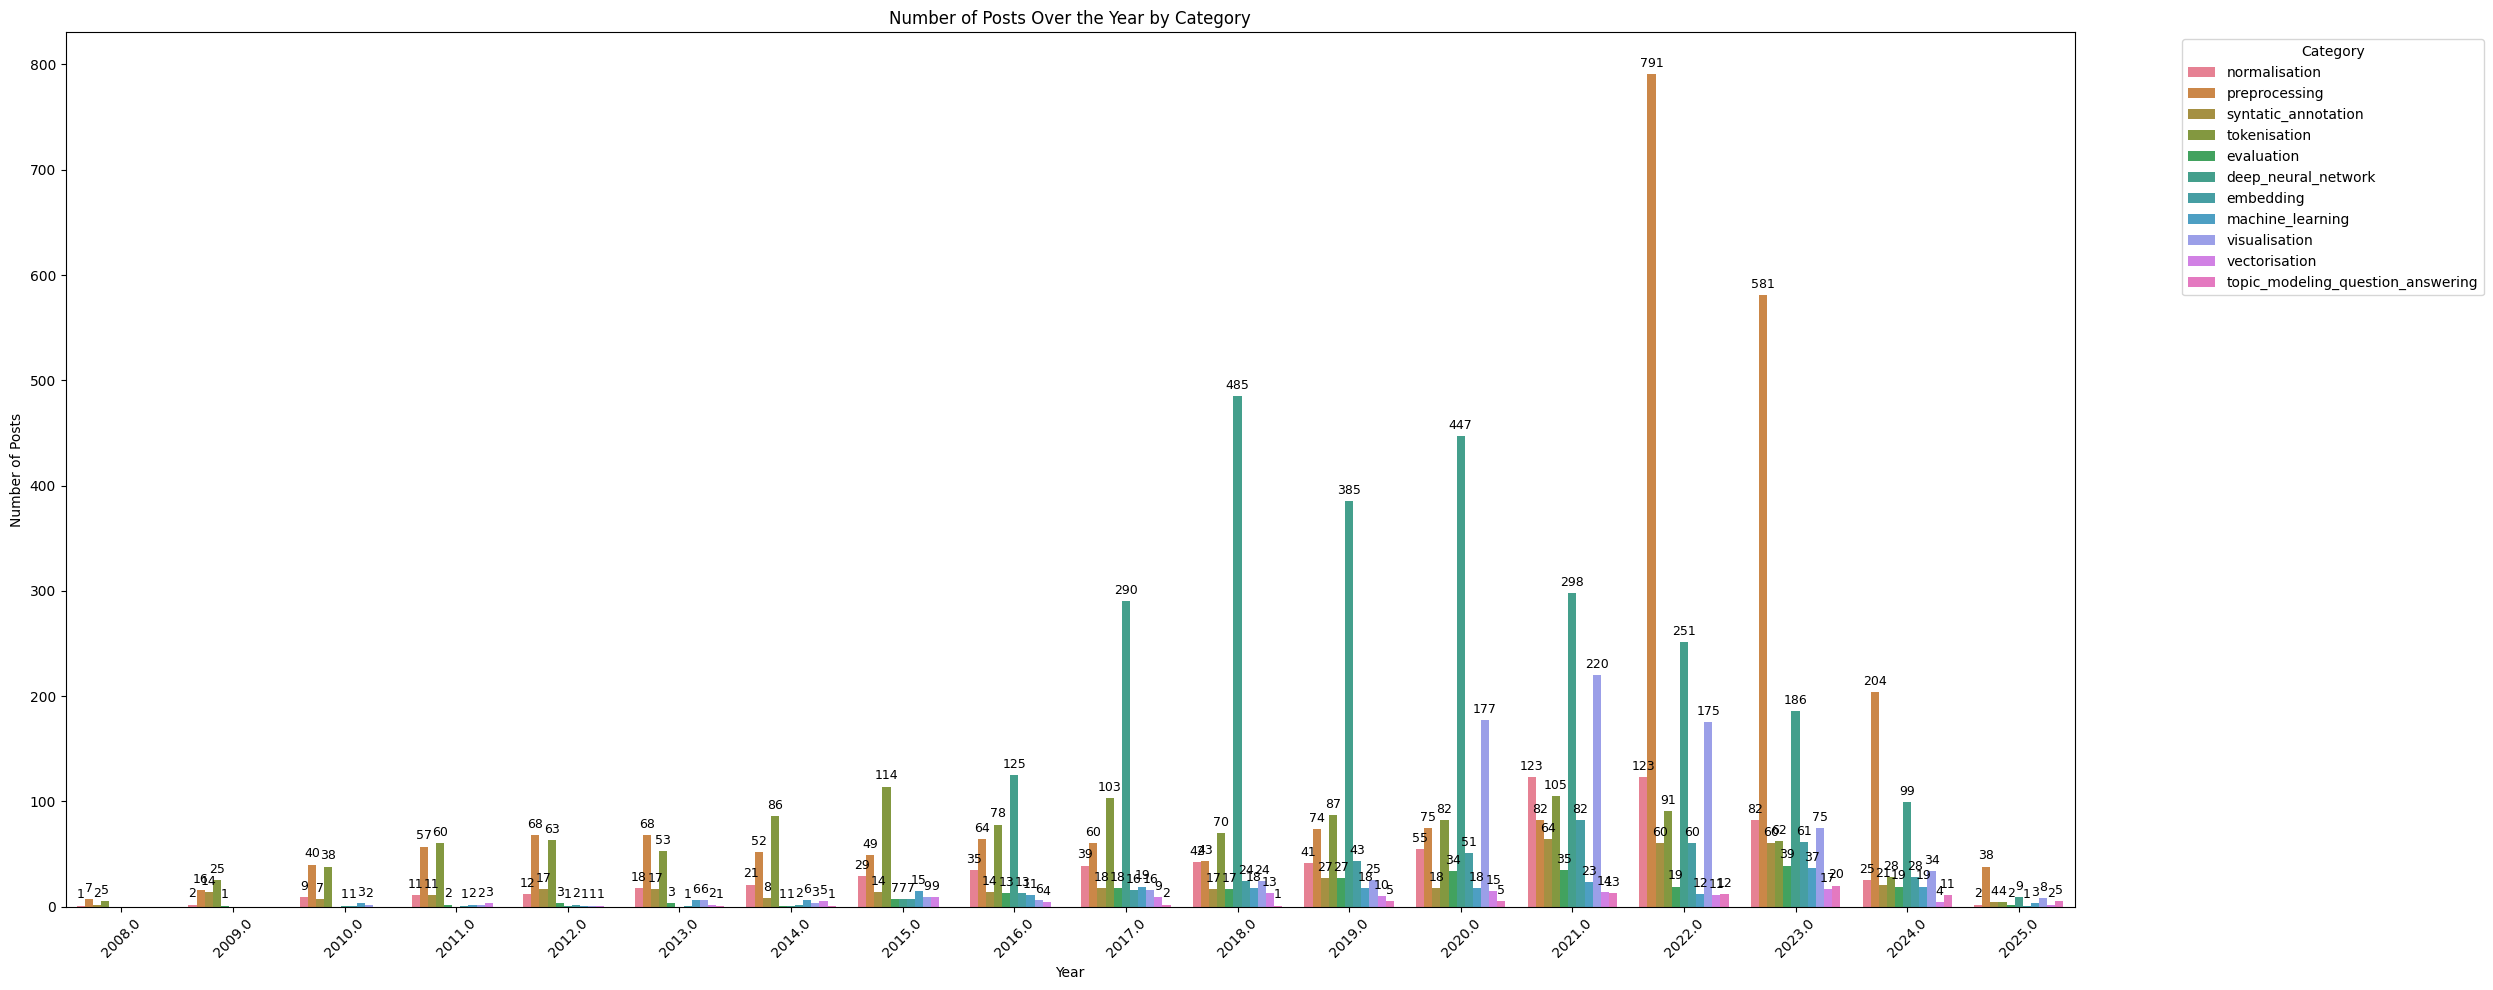

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert the creation_date into datetime and extract the year
final_classification_df['creation_date'] = pd.to_datetime(final_classification_df['creation_date'], unit='s')
final_classification_df['year'] = final_classification_df['creation_date'].dt.year

# Calculate the number posts per year and category
trend_df = final_classification_df.groupby(['year', 'cosine_category']).size().reset_index(name='count')

# Create barchart
plt.figure(figsize=(25, 10))
barplot = sns.barplot(data=trend_df, x='year', y='count', hue='cosine_category', dodge=True)

# Add labels on top of each bar
for container in barplot.containers:
    barplot.bar_label(container, label_type='edge', fontsize=9, padding=3)

plt.title('Number of Posts Over the Year by Category')
plt.xlabel('Year')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45)
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


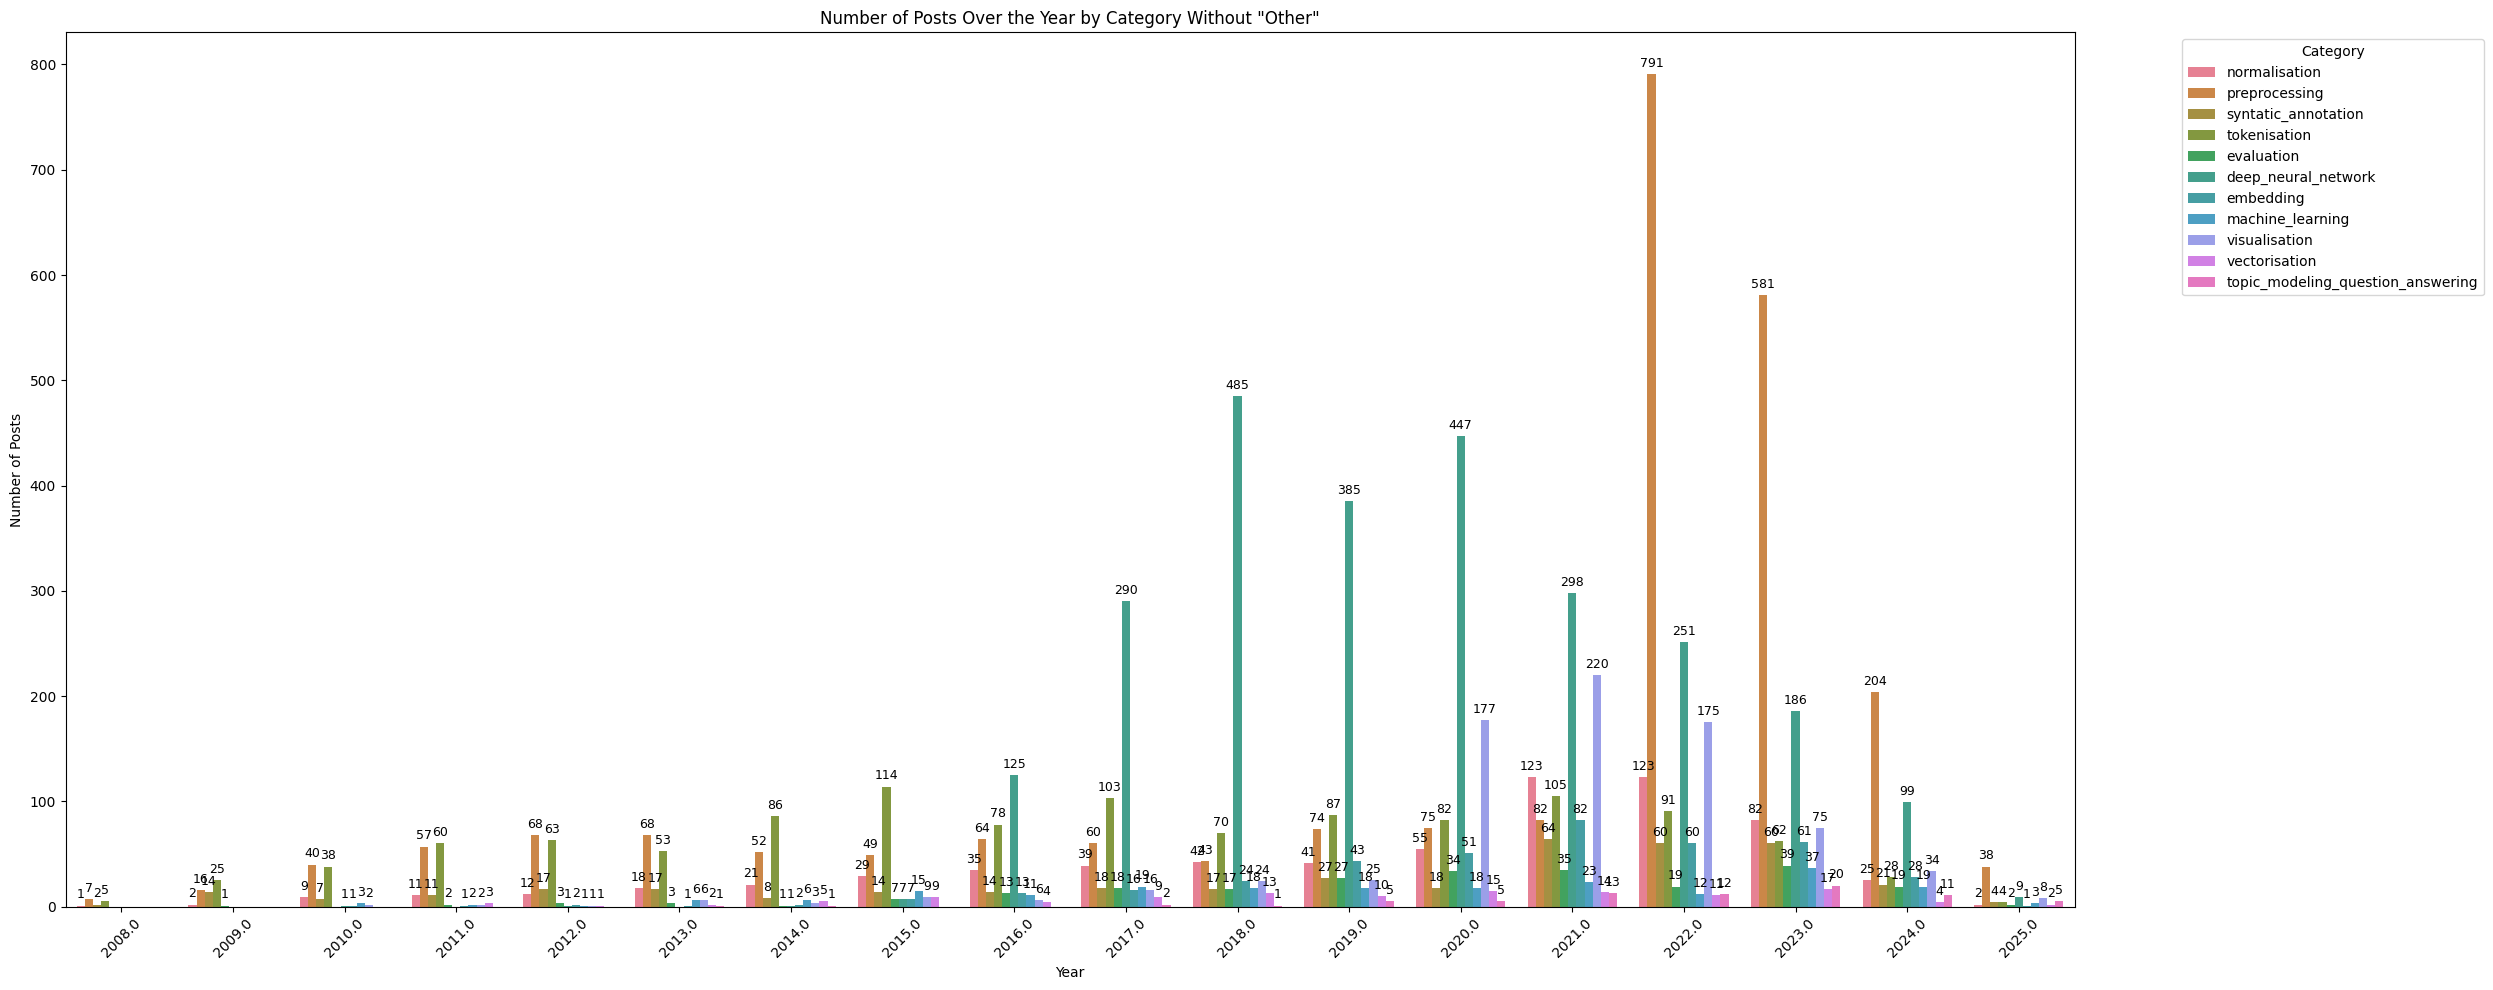

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Exclude 'other' category
final_classification_df_without_other = final_classification_df[final_classification_df['cosine_category']!='other'].copy()

# Calculate the number posts per year and category
trend_df_without_other = final_classification_df_without_other.groupby(['year', 'cosine_category']).size().reset_index(name='count')

# Create barchart
plt.figure(figsize=(25, 10))
barplot = sns.barplot(data=trend_df_without_other, x='year', y='count', hue='cosine_category', dodge=True)

# Add labels on top of each bar
for container in barplot.containers:
    barplot.bar_label(container, label_type='edge', fontsize=9, padding=3)


plt.title('Number of Posts Over the Year by Category Without "Other"')
plt.xlabel('Year')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45)
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
pd.set_option('display.max_colwidth', 1000)

# Show sample of the result
def sample_examples_per_category(df, label_col, n=5, random_state=42):

    sample_df = df.groupby(label_col).apply(lambda x: x.sample(min(n, len(x)), random_state=random_state)).reset_index(drop=True)

    return sample_df[[label_col, 'title', 'body']]

final_classification_sample_df = sample_examples_per_category(final_classification_df, 'cosine_category', 5)
final_classification_sample_df


<ipython-input-21-b3df435137b3>:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_df = df.groupby(label_col).apply(lambda x: x.sample(min(n, len(x)), random_state=random_state)).reset_index(drop=True)


cosine_category  \
0                 deep_neural_network   
1                 deep_neural_network   
2                 deep_neural_network   
3                 deep_neural_network   
4                 deep_neural_network   
5                           embedding   
6                           embedding   
7                           embedding   
8                           embedding   
9                           embedding   
10                         evaluation   
11                         evaluation   
12                         evaluation   
13                         evaluation   
14                         evaluation   
15                   machine_learning   
16                   machine_learning   
17                   machine_learning   
18                   machine_learning   
19                   machine_learning   
20                      normalisation   
21                      normalisation   
22                      normalisation   
23                      normalisation   
24                      normalisation   
25                              other   
26                              other   
27                              other   
28                              other   
29                              other   
30                      preprocessing   
31                      preprocessing   
32                      preprocessing   
33                      preprocessing   
34                      preprocessing   
35                syntatic_annotation   
36                syntatic_annotation   
37                syntatic_annotation   
38                syntatic_annotation   
39                syntatic_annotation   
40                       tokenisation   
41                       tokenisation   
42                       tokenisation   
43                       tokenisation   
44                       tokenisation   
45  topic_modeling_question_answering   
46  topic_modeling_question_answering   
47  topic_modeling_question_answering   
48  topic_modeling_question_answering   
49  topic_modeling_question_answering   
50                      vectorisation   
51                      vectorisation   
52                      vectorisation   
53                      vectorisation   
54                      vectorisation   
55                      visualisation   
56                      visualisation   
57                      visualisation   
58                      visualisation   
59                      visualisation   

                                                                                                                    title  \
0                                                                         What is actually num_unit in LSTM cell circuit?   
1                      Pytorch: RuntimeError: reduce failed to synchronize: cudaErrorAssert: device-side assert triggered   
2                                                                    tensorflow requested = float64_ref, actual = float64   
3                                                                                                Problems with LSTM model   
4                                                                                             batch_first in PyTorch LSTM   
5                                                                                             Sentence embedding using T5   
6                               Fasttext pre-trained model is not producing OOV word vectors when using gensim downloader   
7                                             Can I concatenate an Embedding layer with a layer of shape (?, 5) in keras?   
8                                                                      Python too slow to find text in string in for loop   
9                                                                                 Document Features Vector Representation   
10                                                        Neural network predicts very poorly though it has high accuracy   
11                  

# References:

1. Stack Exchange 2025, *Stack Exchange API v2.3*, Stack Exchange, viewed 13 April 2025, <https://api.stackexchange.com/docs>.
2. Axelborn, H & Berggren, J 2023, 'Topic modeling for customer insights: a comparative analysis of LDA and BERTopic in categorizing customer calls.', MA thesis, Umeå University, Sweden, <https://www.diva-portal.org/smash/record.jsf?pid=diva2%3A1763637&dswid=-9433>.
3. Feng, Z, Guo, D, Tang, D, Duan, N., Feng, X, Gong, M, Shou, L, Qin, B, Liu, T, Jiang, D & Zhou, M 2020, 'Codebert: A pre-trained model for programming and natural languages.', *Findings of the Association for Computational Linguistics: EMNLP 2020*, pp.1536-1547.